# Flight Dynamics Surrogate Model for High-Altitude Stall Upset
Author: Mohamad Hamza, Arizona State University 

Email: mhamza1@asu.edu

## Part 1: Surrogate  Model

This notebook shows a demonstration of using a surrogate model for high-altitude stall upset. 

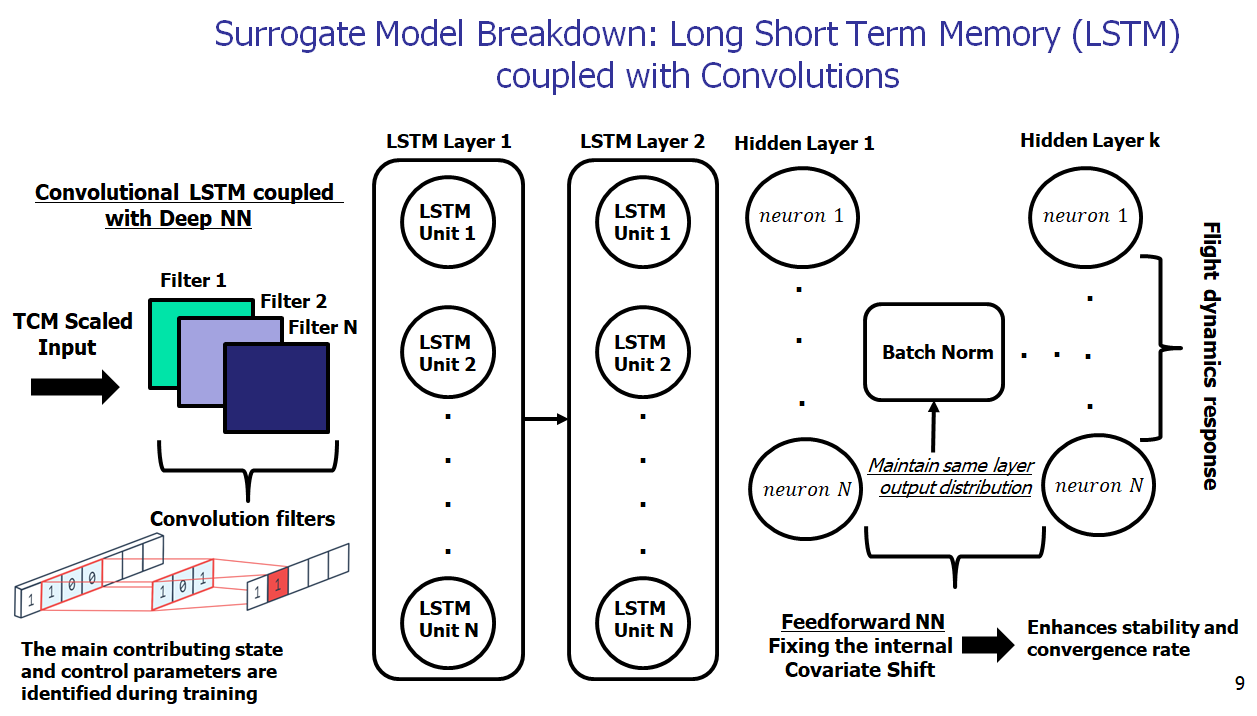

## Part 1: Surrogate  Model

This notebook shows a demonstration of using a surrogate model for high-altitude stall upset. 

## Code Requirements

The Python packages required to run this module are:
- **[```tensorflow```]**
    - Tensorflow is an end-to-end open source platform for machine learning. It has a comprehensive, flexible ecosystem of tools and libraries.
    
- **[```keras```]**
    - A Python deep learning API.
 
This is in addition to ```numpy```, ```os```,```pandas```,  and ```matplotlib```.

## Data Requirements

A user of this code will need to access and download the training data from the Transport Class Model (TCM) simulations. That data can be found [here](https://1drv.ms/u/s!Aiwxve5lUeA1gqge3JPojtWFMMxhPA?e=DggKrW). The user will then need to store the data on their system and have the directory location assigned as the variable `DataDir` below. 

## Procedure 1: Setup of Machine Learning Surrogate
### Step 1.1 Input and Output Directories

In [26]:
DataDir = "Data"
outDir = "Results_ML"

### Step 1.2 Machine Learning Surrogate Model Setup
First we determine if we want to use an existing model or train a new one with data in `DataDir`. For this demonstration, we want to use an existing model contained in the file `surrogateModel.h5`. As such, we set the variable `trainingMode` to 0 to indicate use of an existing model. If we want to train the surrogate with new data, we would set `trainingMode` to 1. 

In [27]:
trainingMode = 0 #if training model, it will be 1. if you just want to use an existing model, use 0. 

The parameters below are control parameters for the machine learning model. In particular we have to indicate `window_size`, number of batches used for training (`btch_sz`), `shuffle_buffer_size` to control memory by randomly selecting batches from the data, `trainingEpochs` indicating the number of iterations for model training, the timestep of the model prediction (`gtm_dt`), and the initial time (`InitialT`).

Note: For this demonstration we assign the number of training epochs (`trainingEpochs`) to 2, however, in actuality this number should be increased to improve the resulting model. In general, a minimum of 1000 training epochs should be used to observe monotonic decrease of the loss function. 

In [28]:
window_size = 20 # How many previous time steps will be used to predict the current time step
btch_sz = 32 # Batches for training
shuffle_buffer_size = 1000 # just to speed up the shuffling (optional)
trainingEpcohs = 2 #5000
gtm_dt = 0.005
InitialT = 0

## Procedure 2: Manipulating Training Data 

## Step 2.2 Reading and Scaling Training Data


In [29]:
from utils import read_input, getCI, getTime

allTraj = read_input(DataDir)
scaled_Data,gtm_trj_ToBe_scaled,orignalData = getCI(allTraj,0)

TotalTime = getTime(scaled_Data.shape[0],gtm_dt)
print(TotalTime)

Done reading Data with size	 (1, 1, 1)


ValueError: negative dimensions are not allowed

## Step 2.2 Split Data into Training and Testing Datasets

In [19]:
from utils import train_split
x_train, x_valid = train_split(scaled_Data,0.8)

NameError: name 'scaled_Data' is not defined

## Step 2.3 Convert Data into Time Windows
Here where n previous steps (window size) are used to predict the current steps

In [22]:
from utils import windowed_dataset, dataSet_numpy

dataset = windowed_dataset(x_train, window_size, btch_sz, shuffle_buffer_size)
dataSetX, dataSetY = dataSet_numpy(btch_sz,window_size,x_train.shape[1],dataset)

NameError: name 'x_train' is not defined

## Procedure 3: Get Surrogate Model
### Step 3.1 Train Surrogate OR Load Pre-Trained Surrogate

In [24]:
from utils import myLSTM_DNN_Conv, load_model

if trainingMode ==1:
  model = myLSTM_DNN_Conv(window_size,x_train.shape[1],0)
  history = model.fit(dataSetX,dataSetY,batch_size=btch_sz, epochs=trainingEpcohs,verbose=1)
  history.model.save(r'surrogateModel.h5')
else:
  model = load_model('surrogateModel.h5')

NotImplementedError: Cannot convert a symbolic Tensor (bidirectional/forward_lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

### Step 3.2 Evaluate Loss Function over Epochs (if `trainingMode = 1`)

In [7]:
from utils import plotLoss
if trainingMode ==1:
  loss = history.history['loss']
  epochs = range(len(loss))
  plotLoss(epochs,loss,outDir)

In [25]:
from utils import windowed_dataset_predict

dataset_val = windowed_dataset_predict(scaled_Data,window_size, btch_sz)
dataSetX_val, dataSetY_val = dataSet_numpy(btch_sz,window_size,scaled_Data.shape[1],dataset_val)

NameError: name 'scaled_Data' is not defined

## Procedure 4: Use Surrogate Model in Prediction

### Step 4:1 Make Predictions

In [11]:
from utils import predict

predictedData = predict(model,gtm_trj_ToBe_scaled,dataSetX_val,dataSetY_val,btch_sz)
np.savetxt("CLSTM_PredictedProjectionV0TCM.csv", predictedData, delimiter=",")

### Step 4.2 Plot Predictions

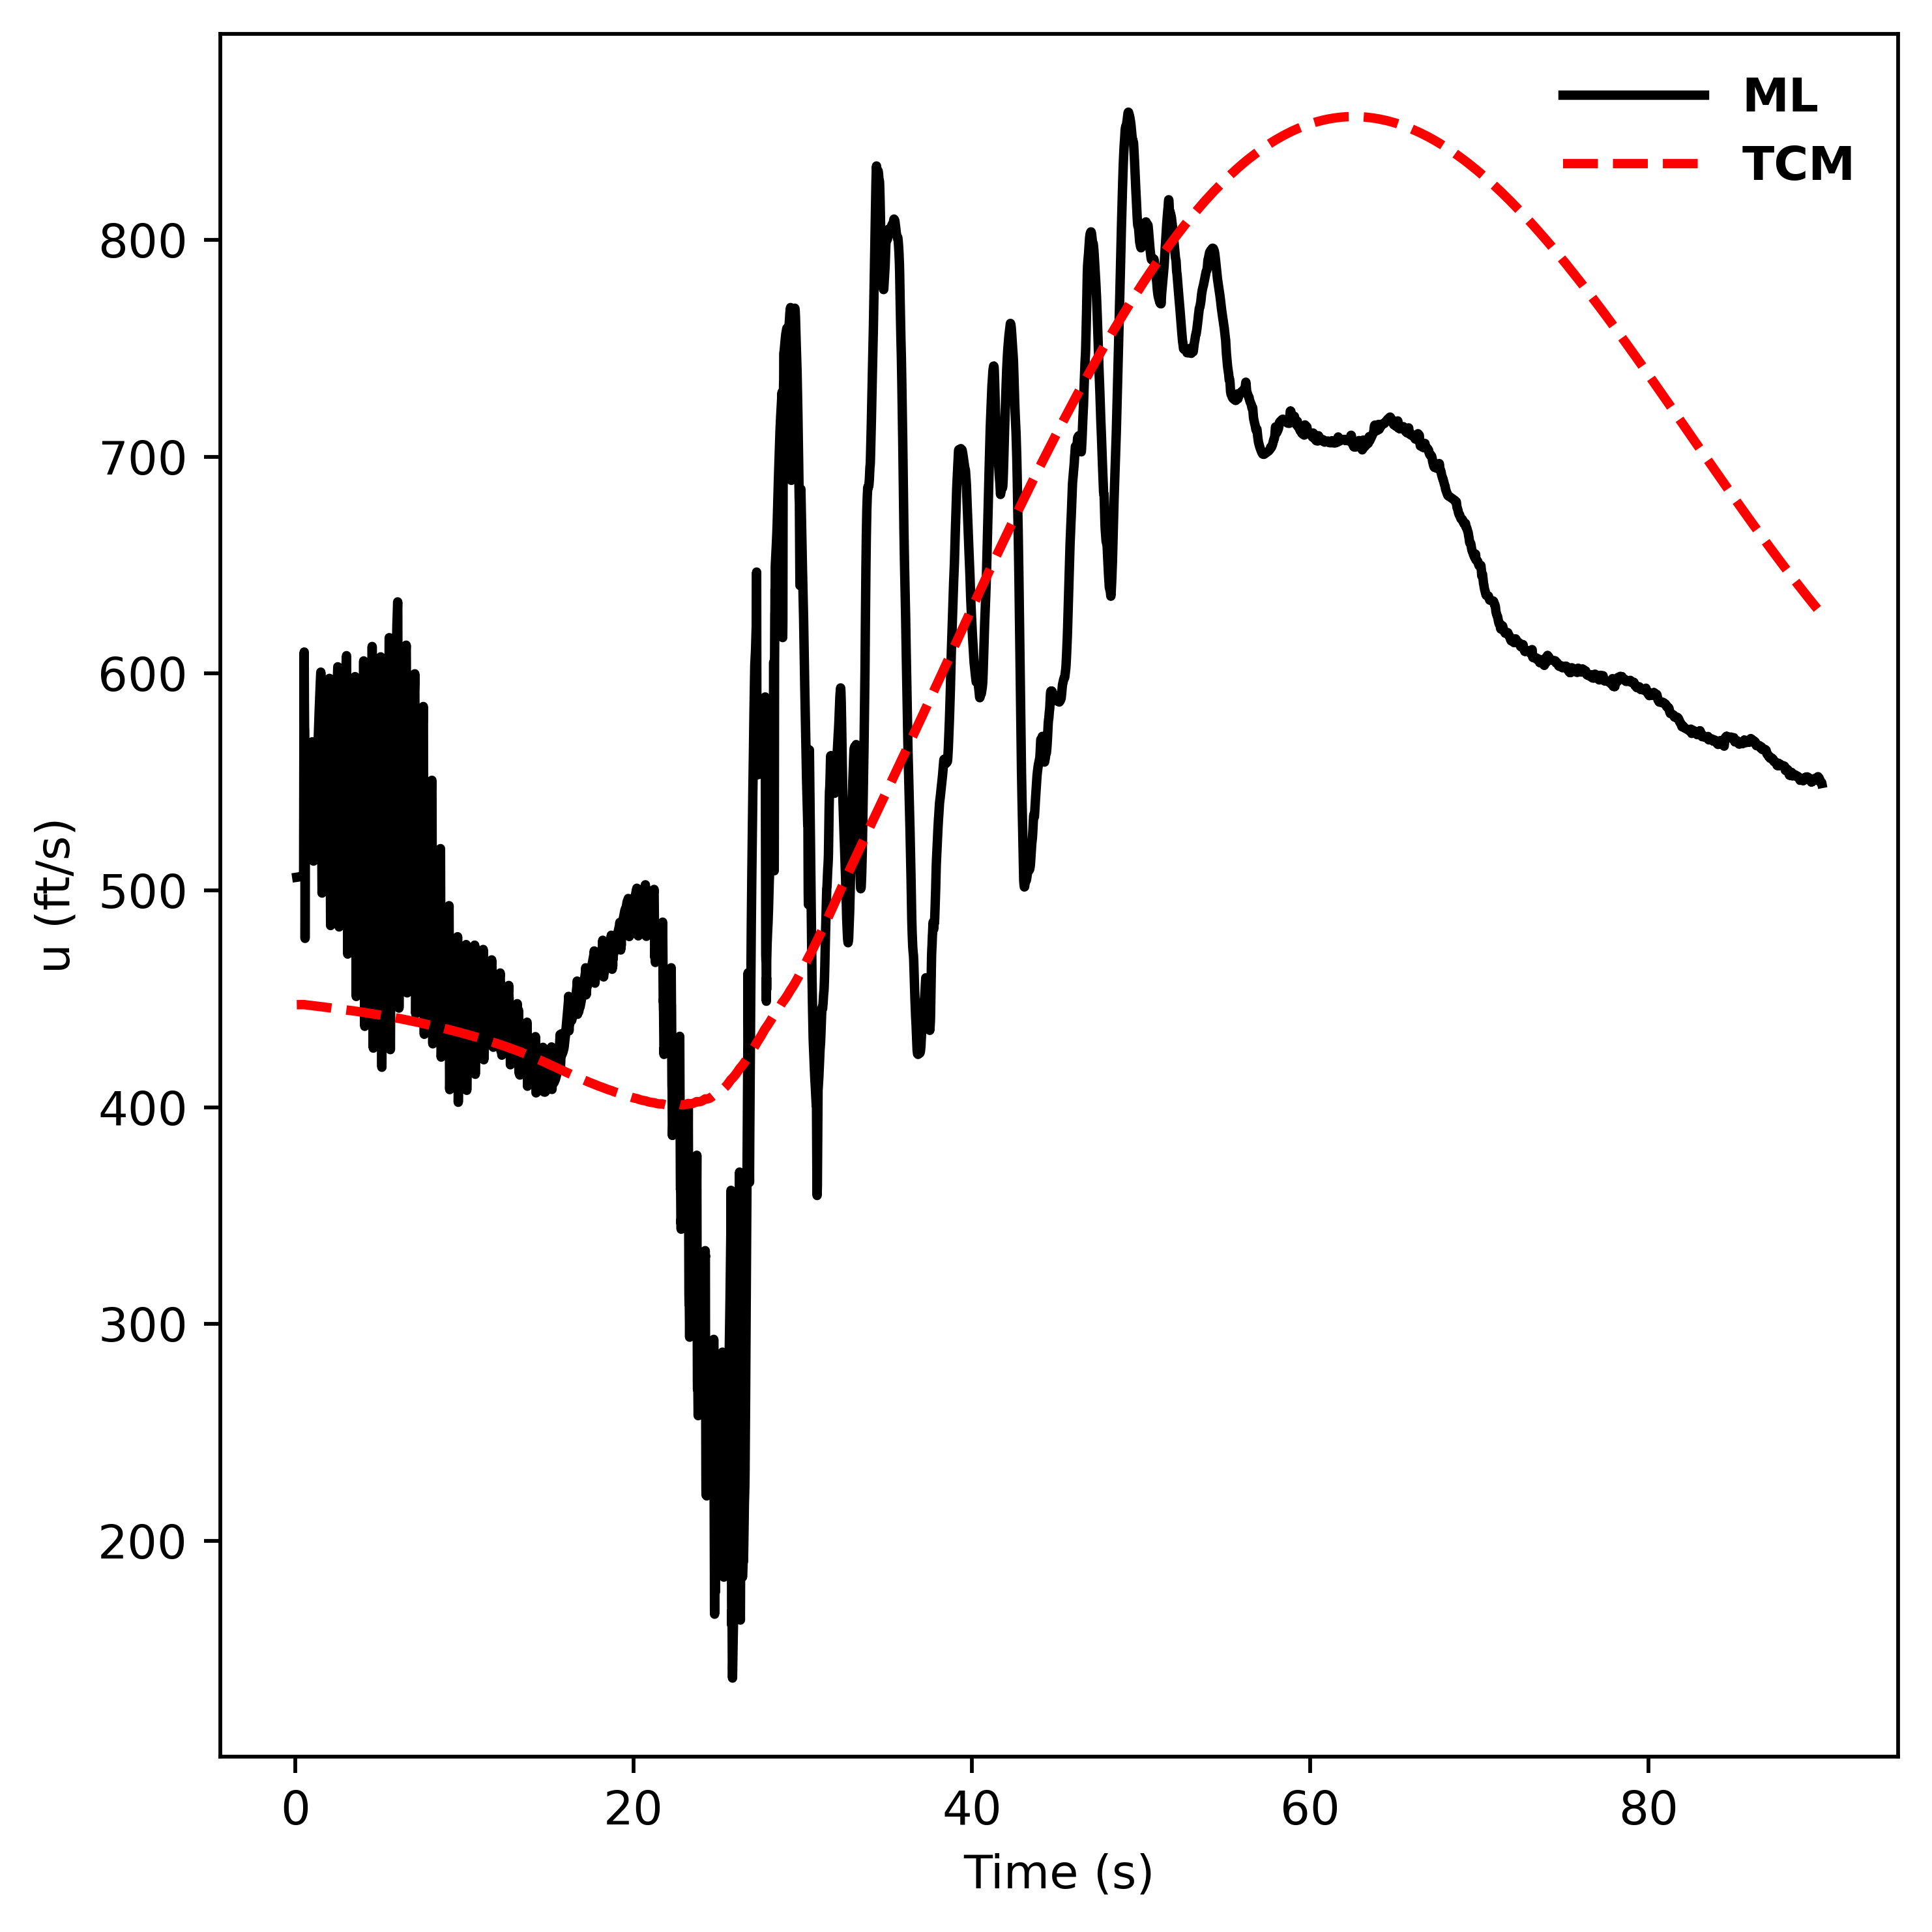

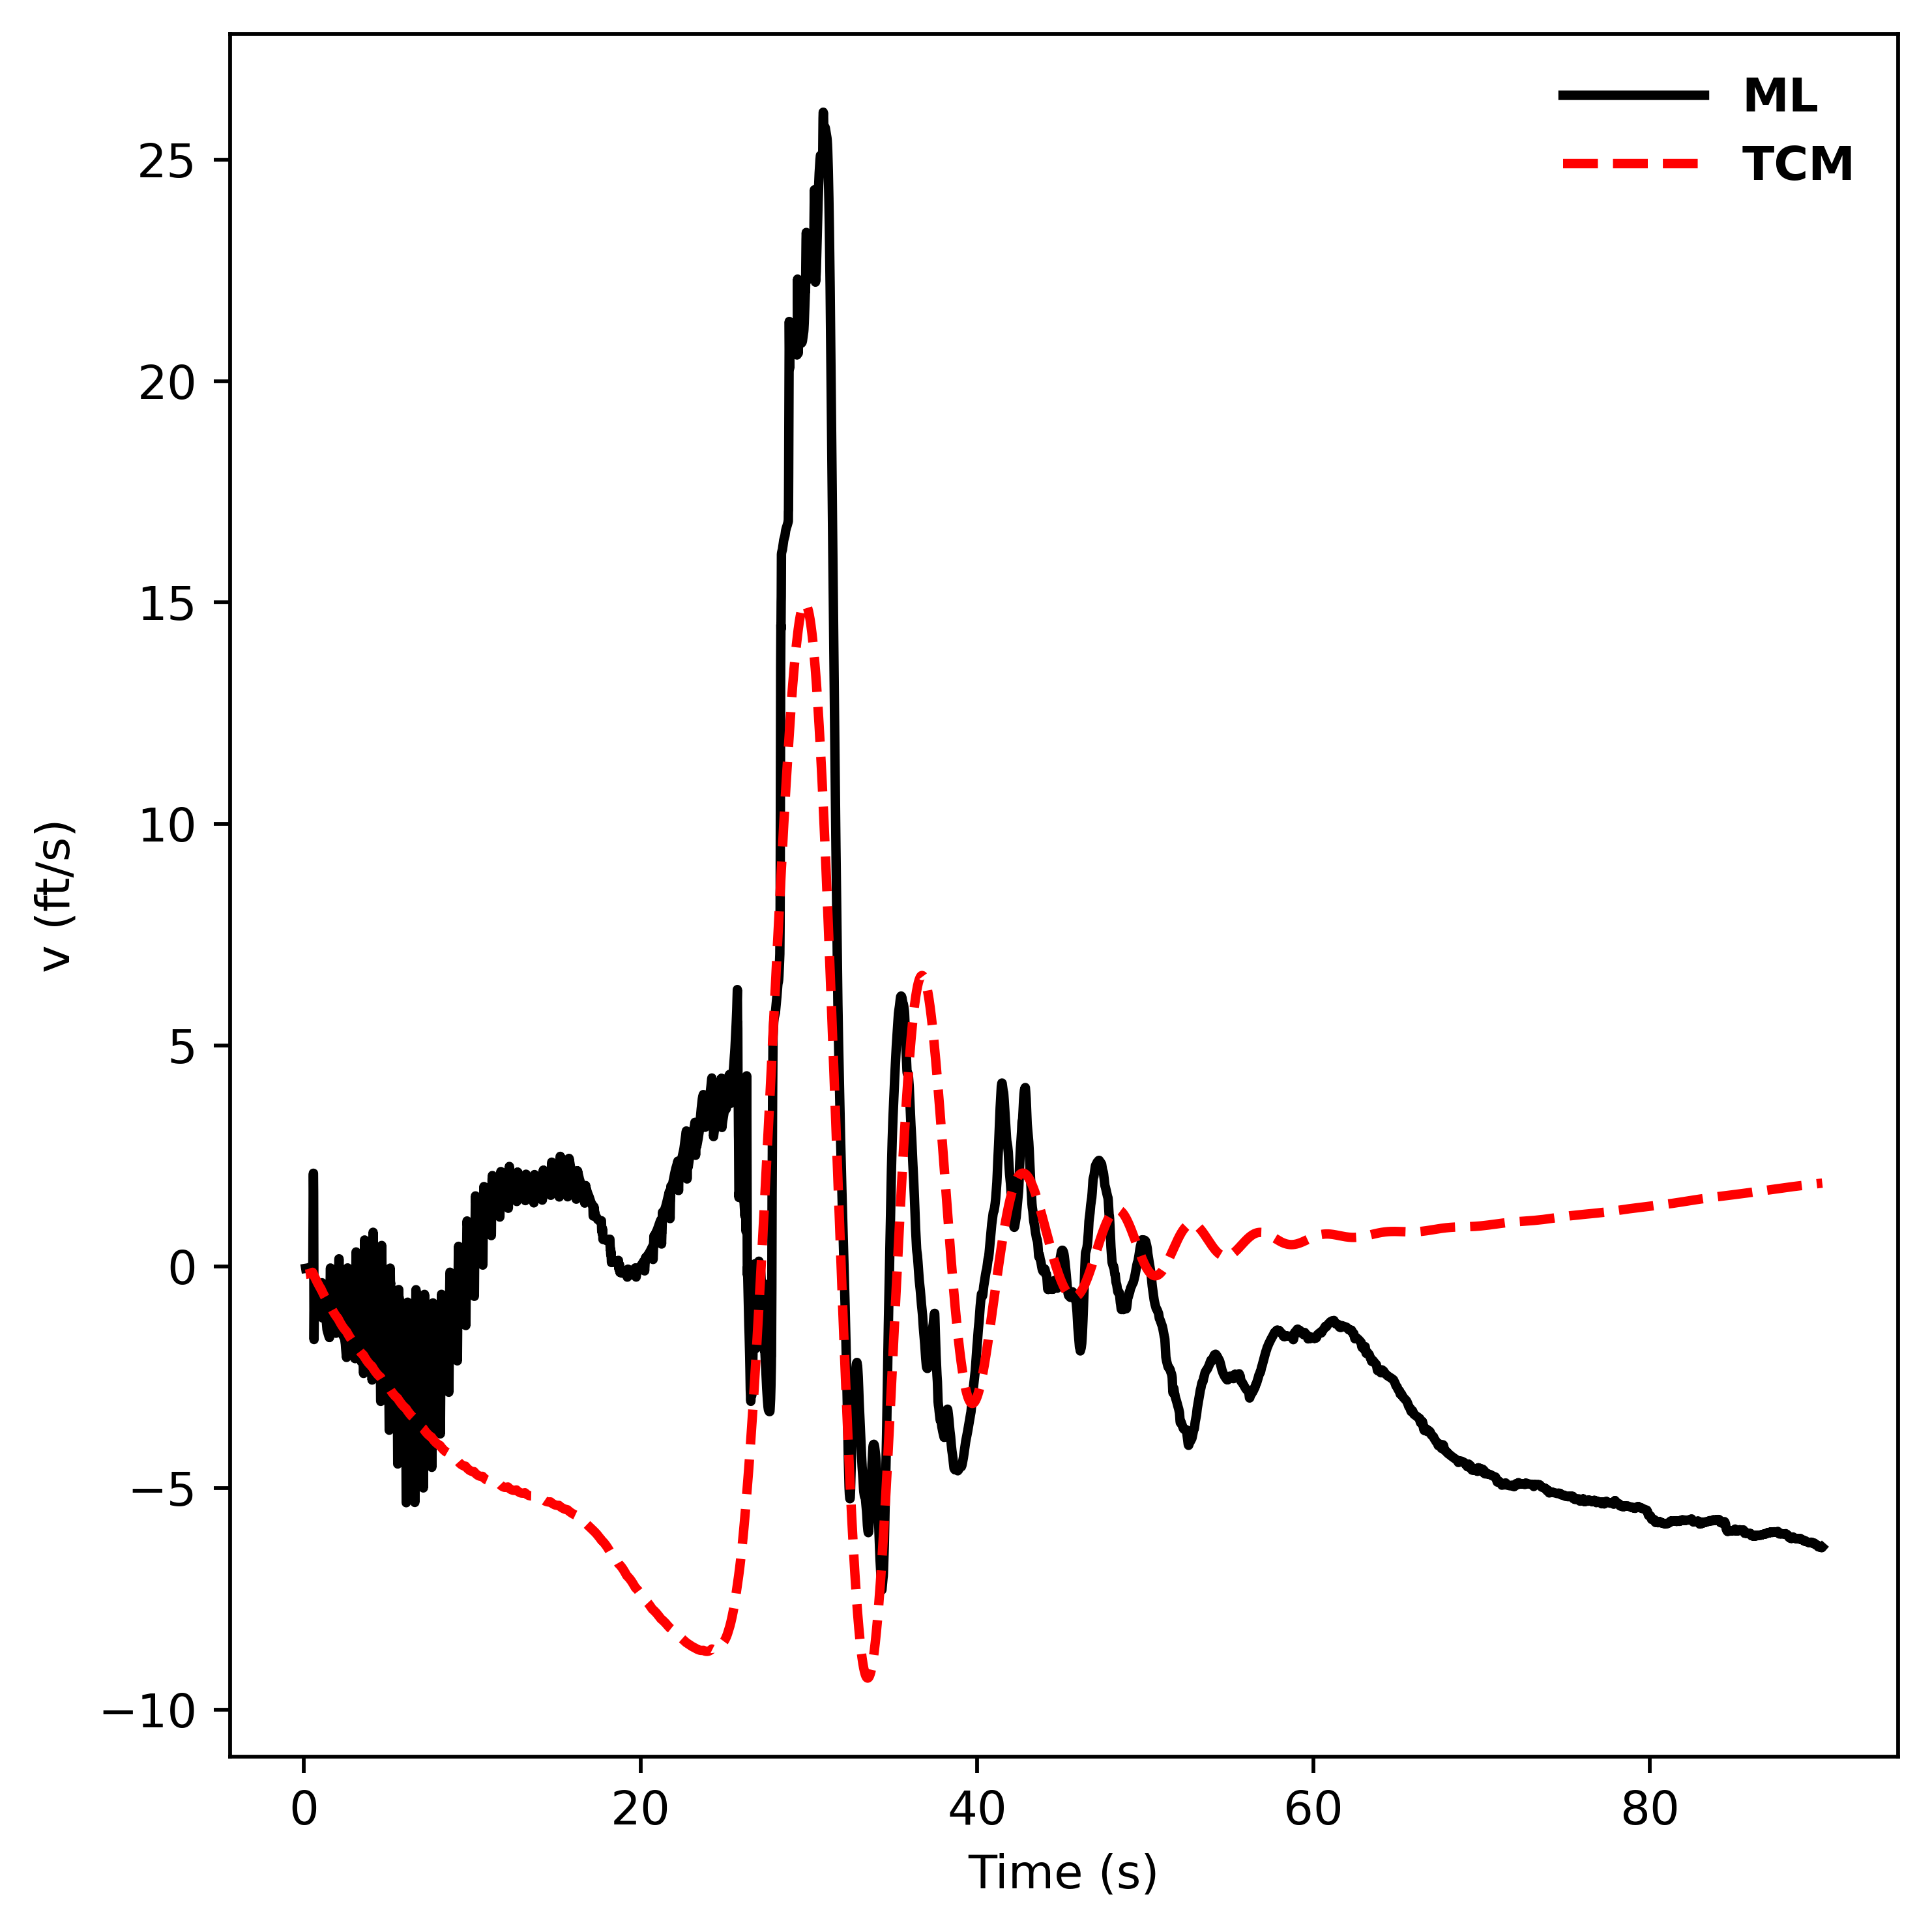

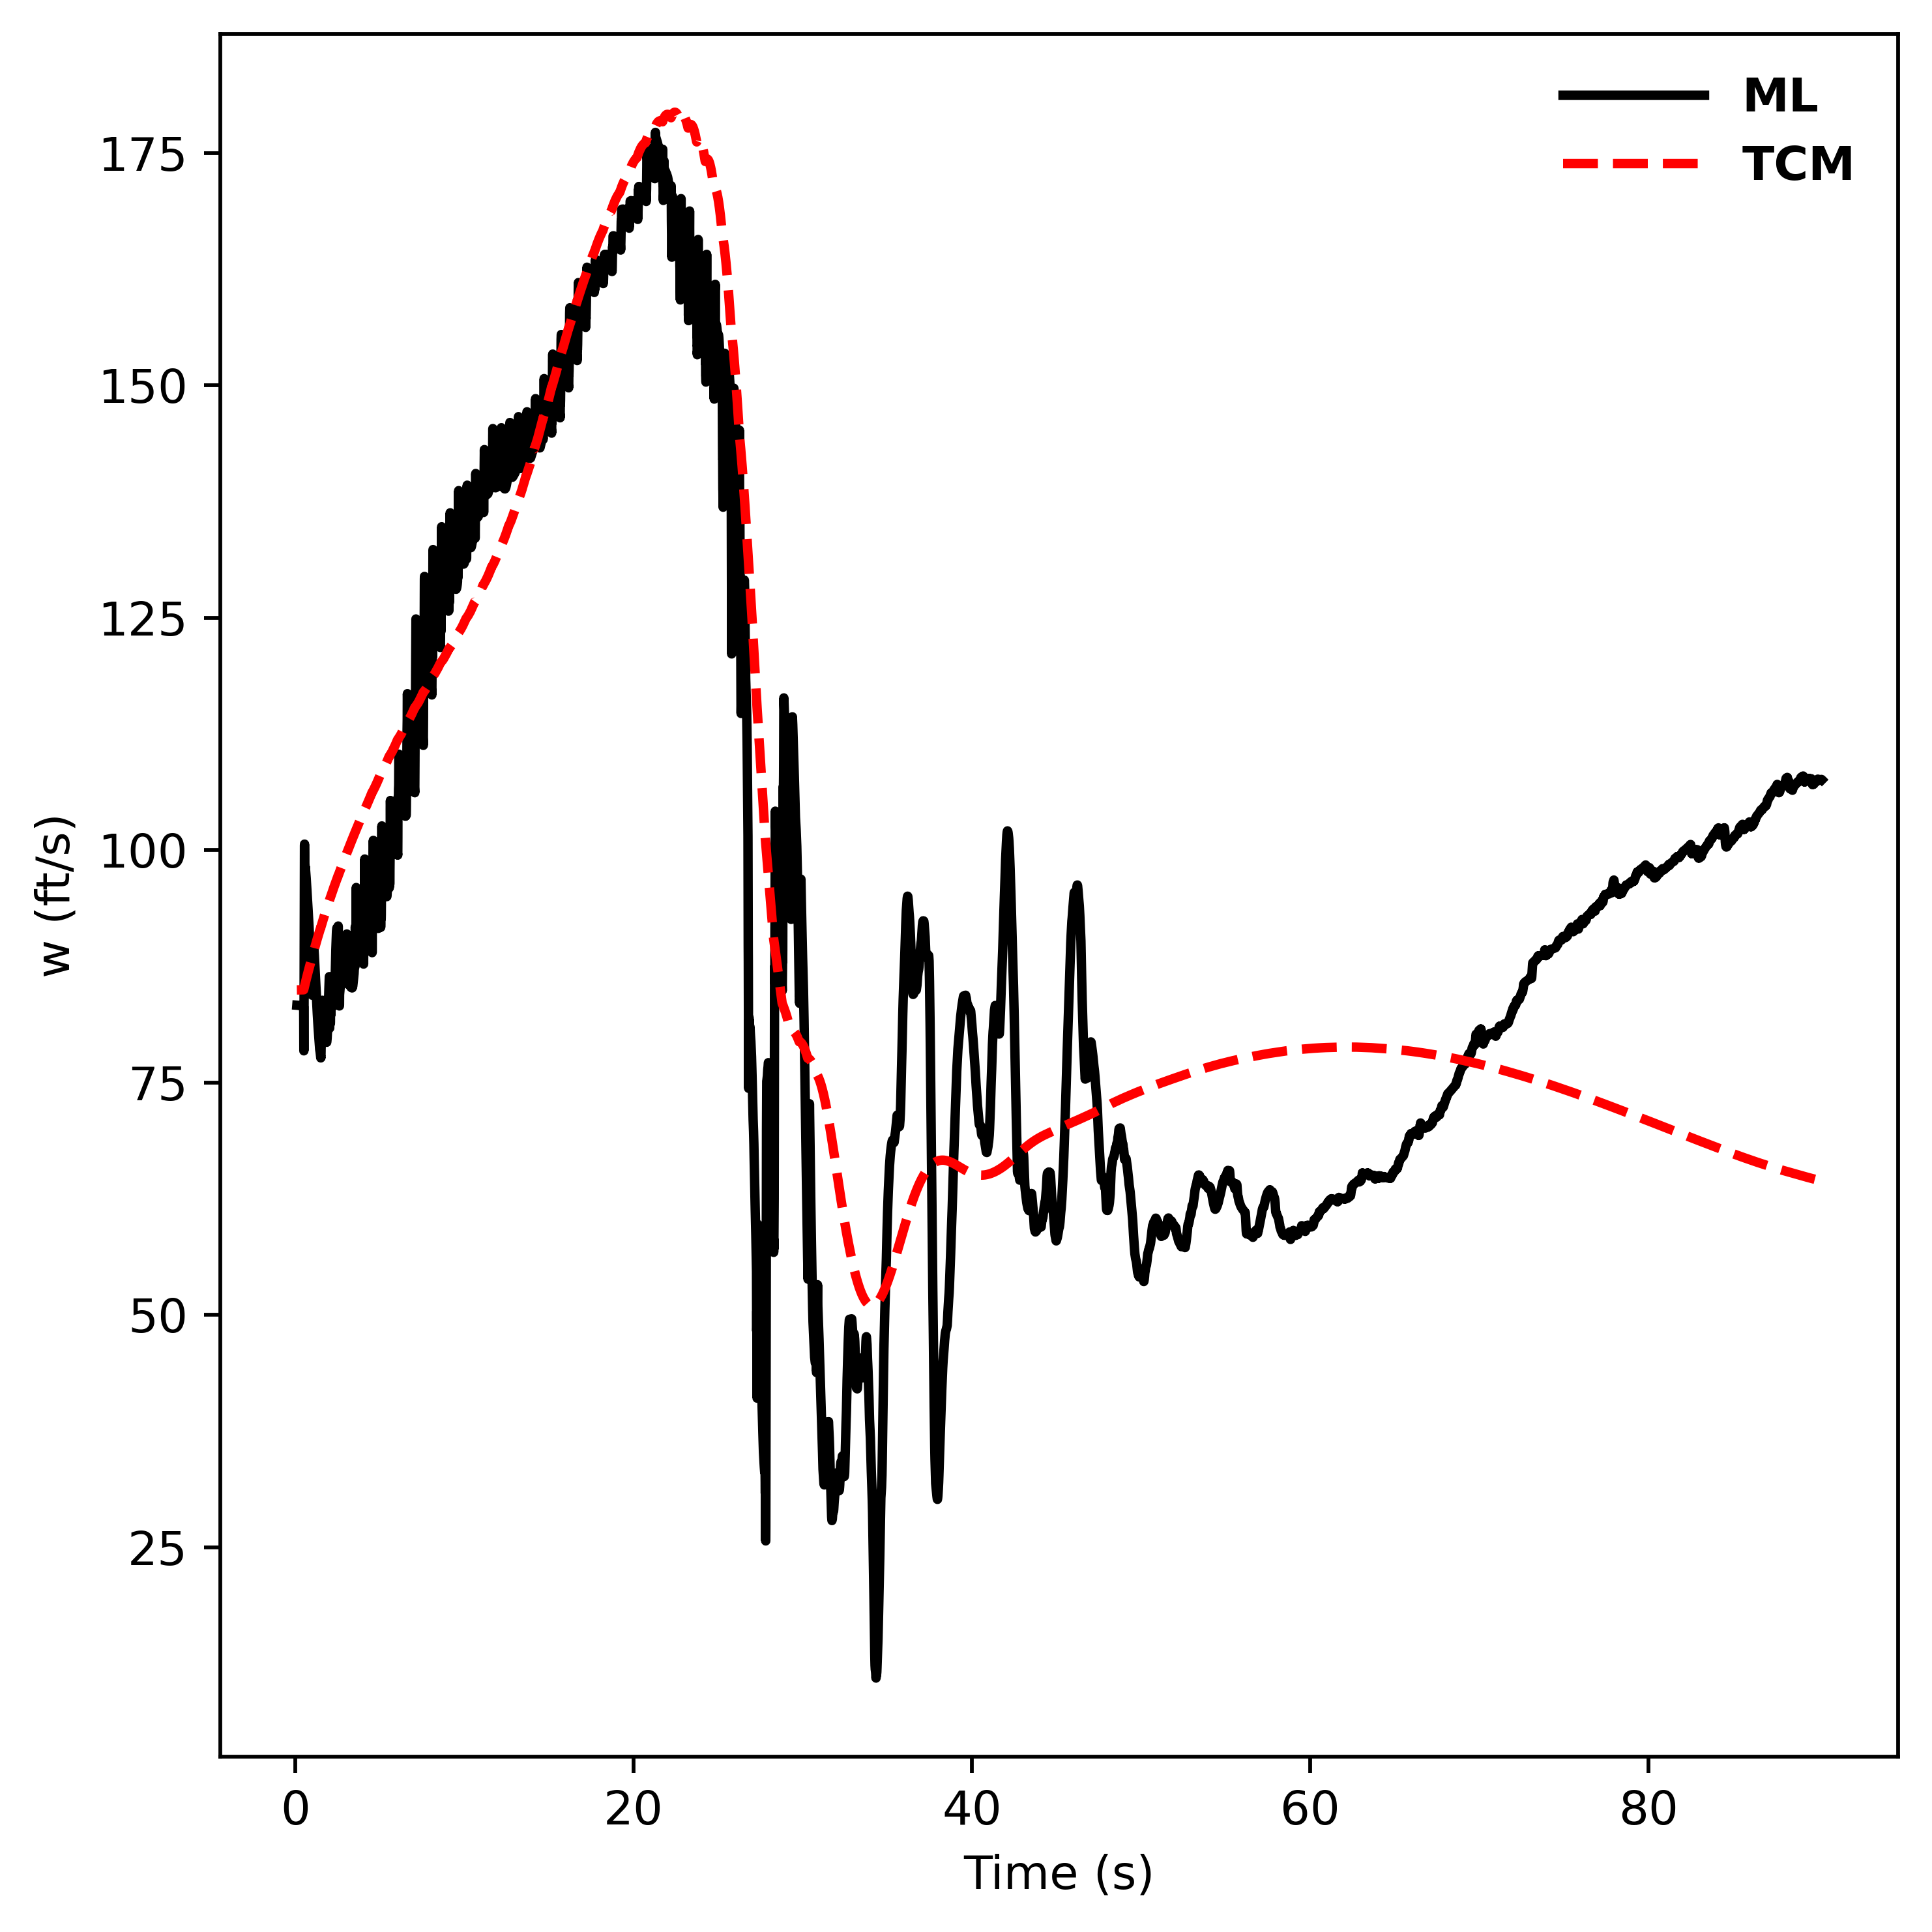

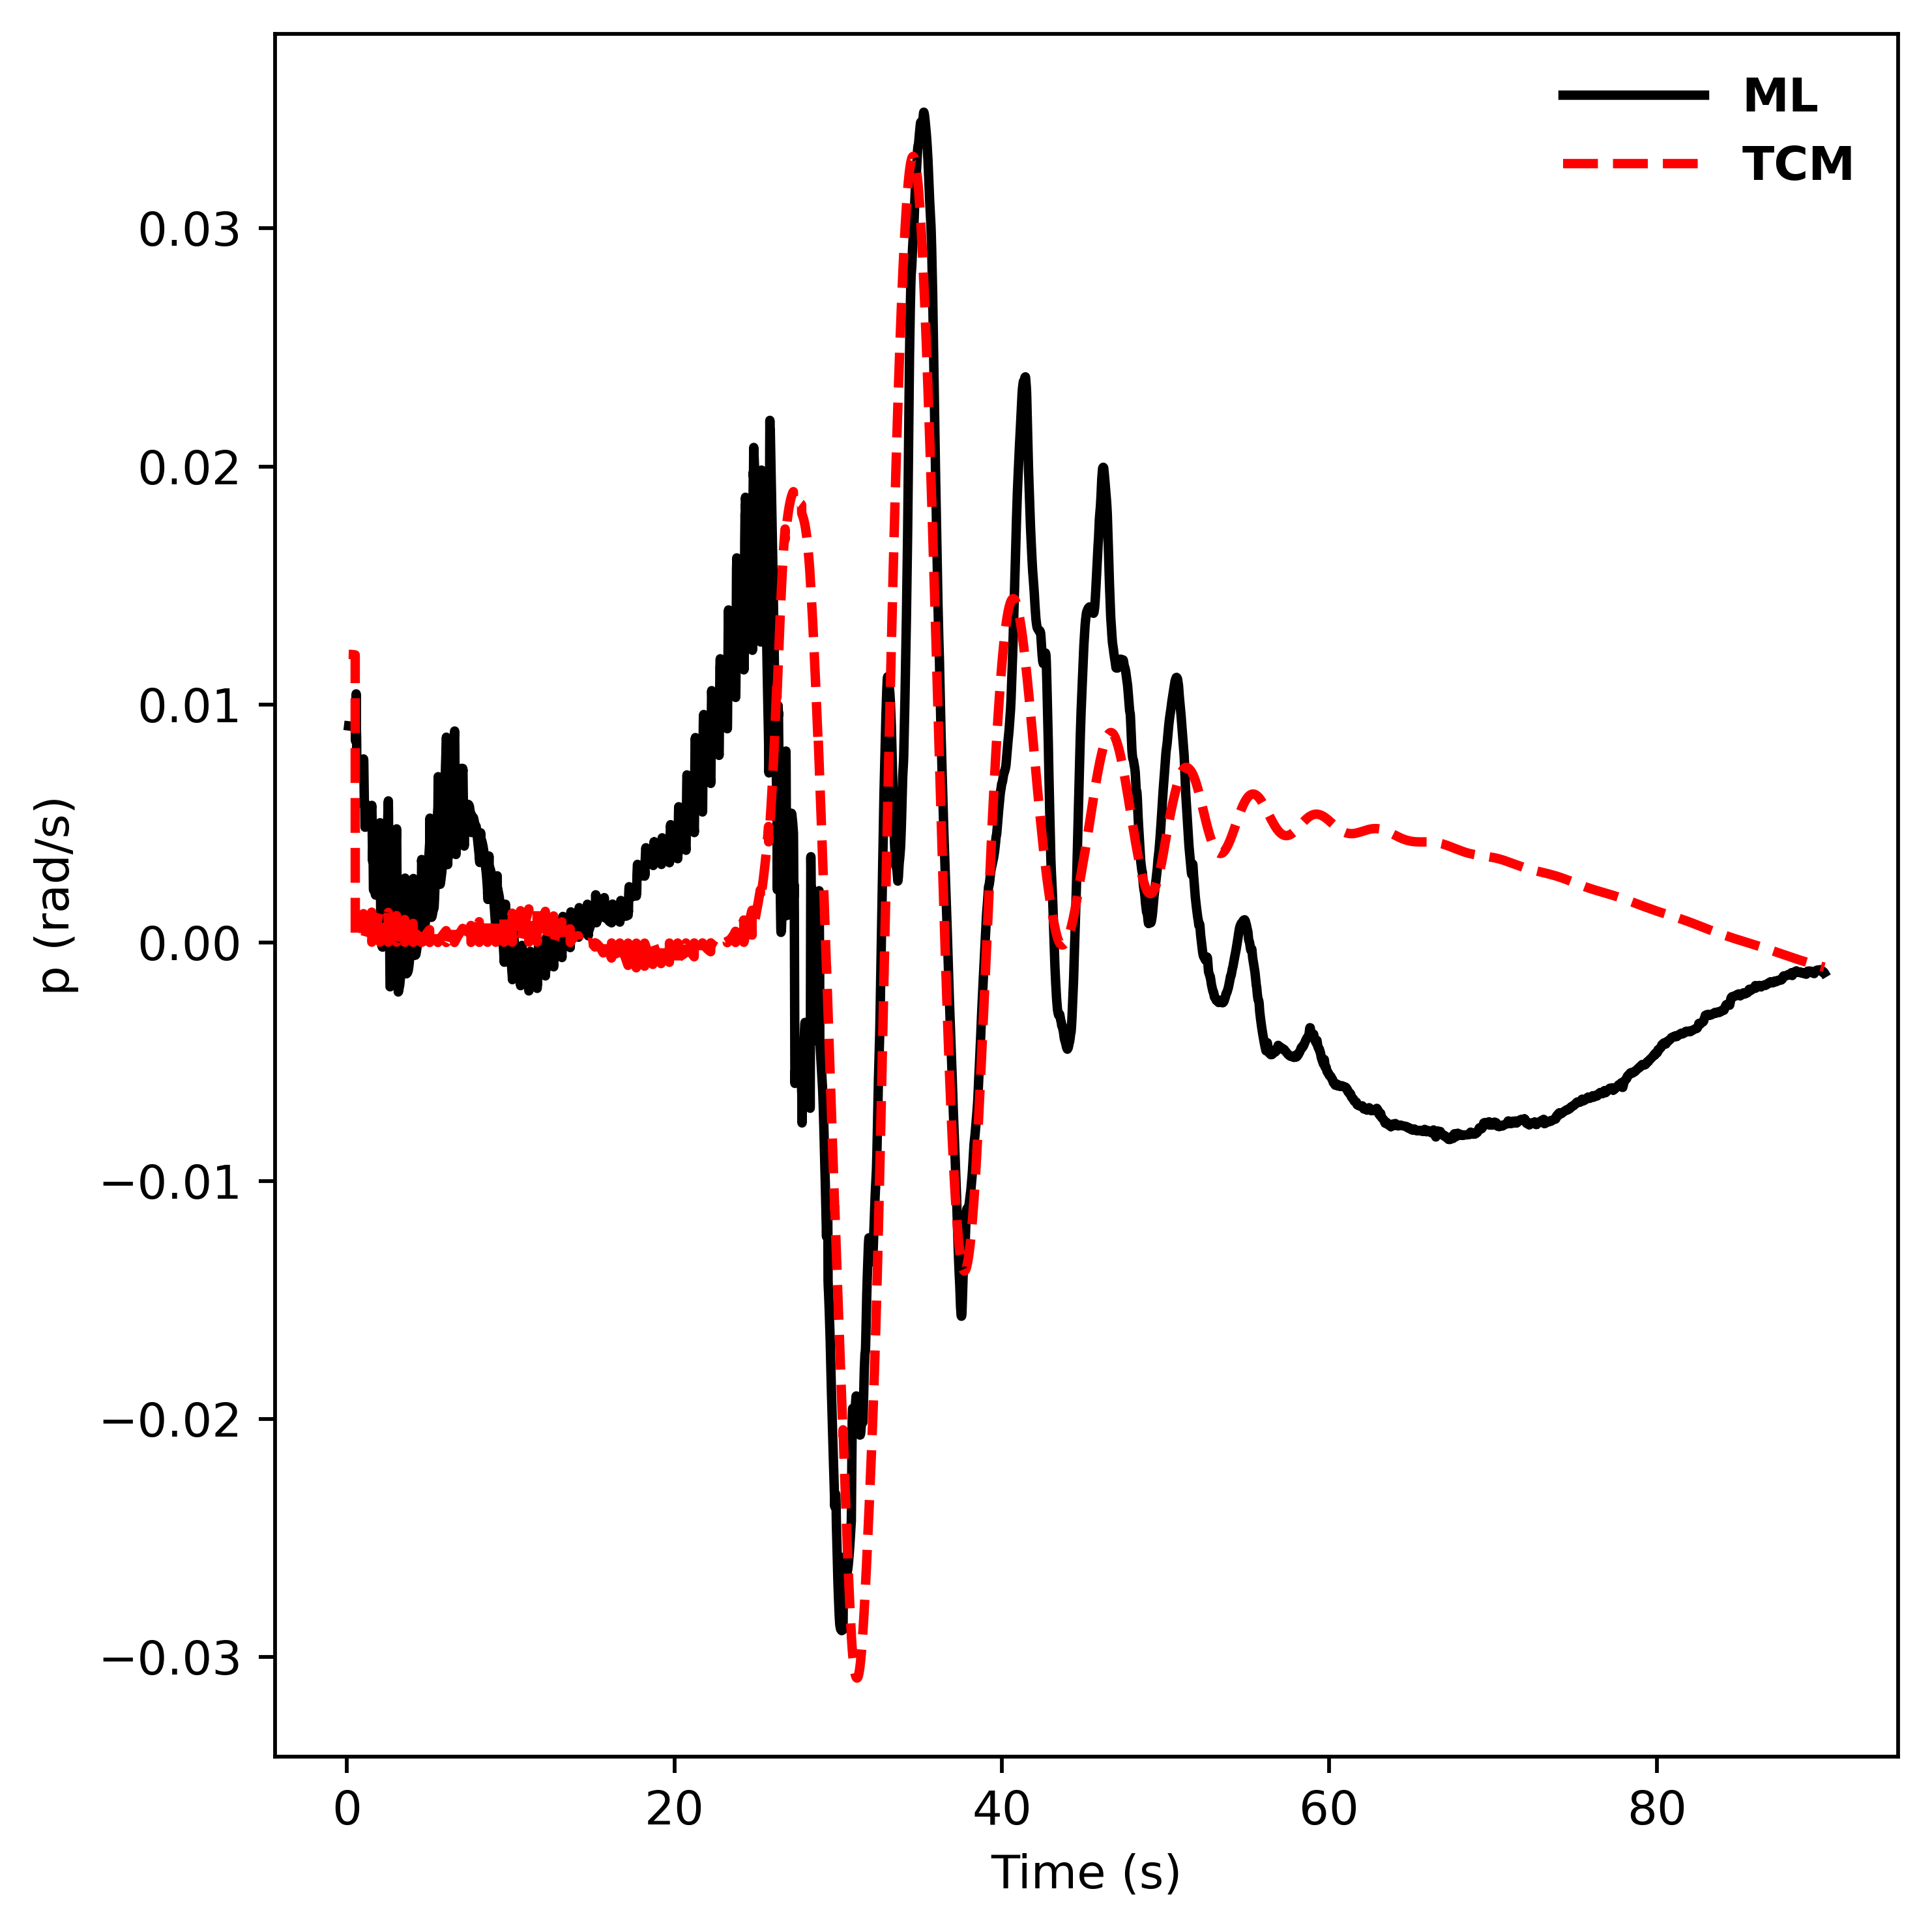

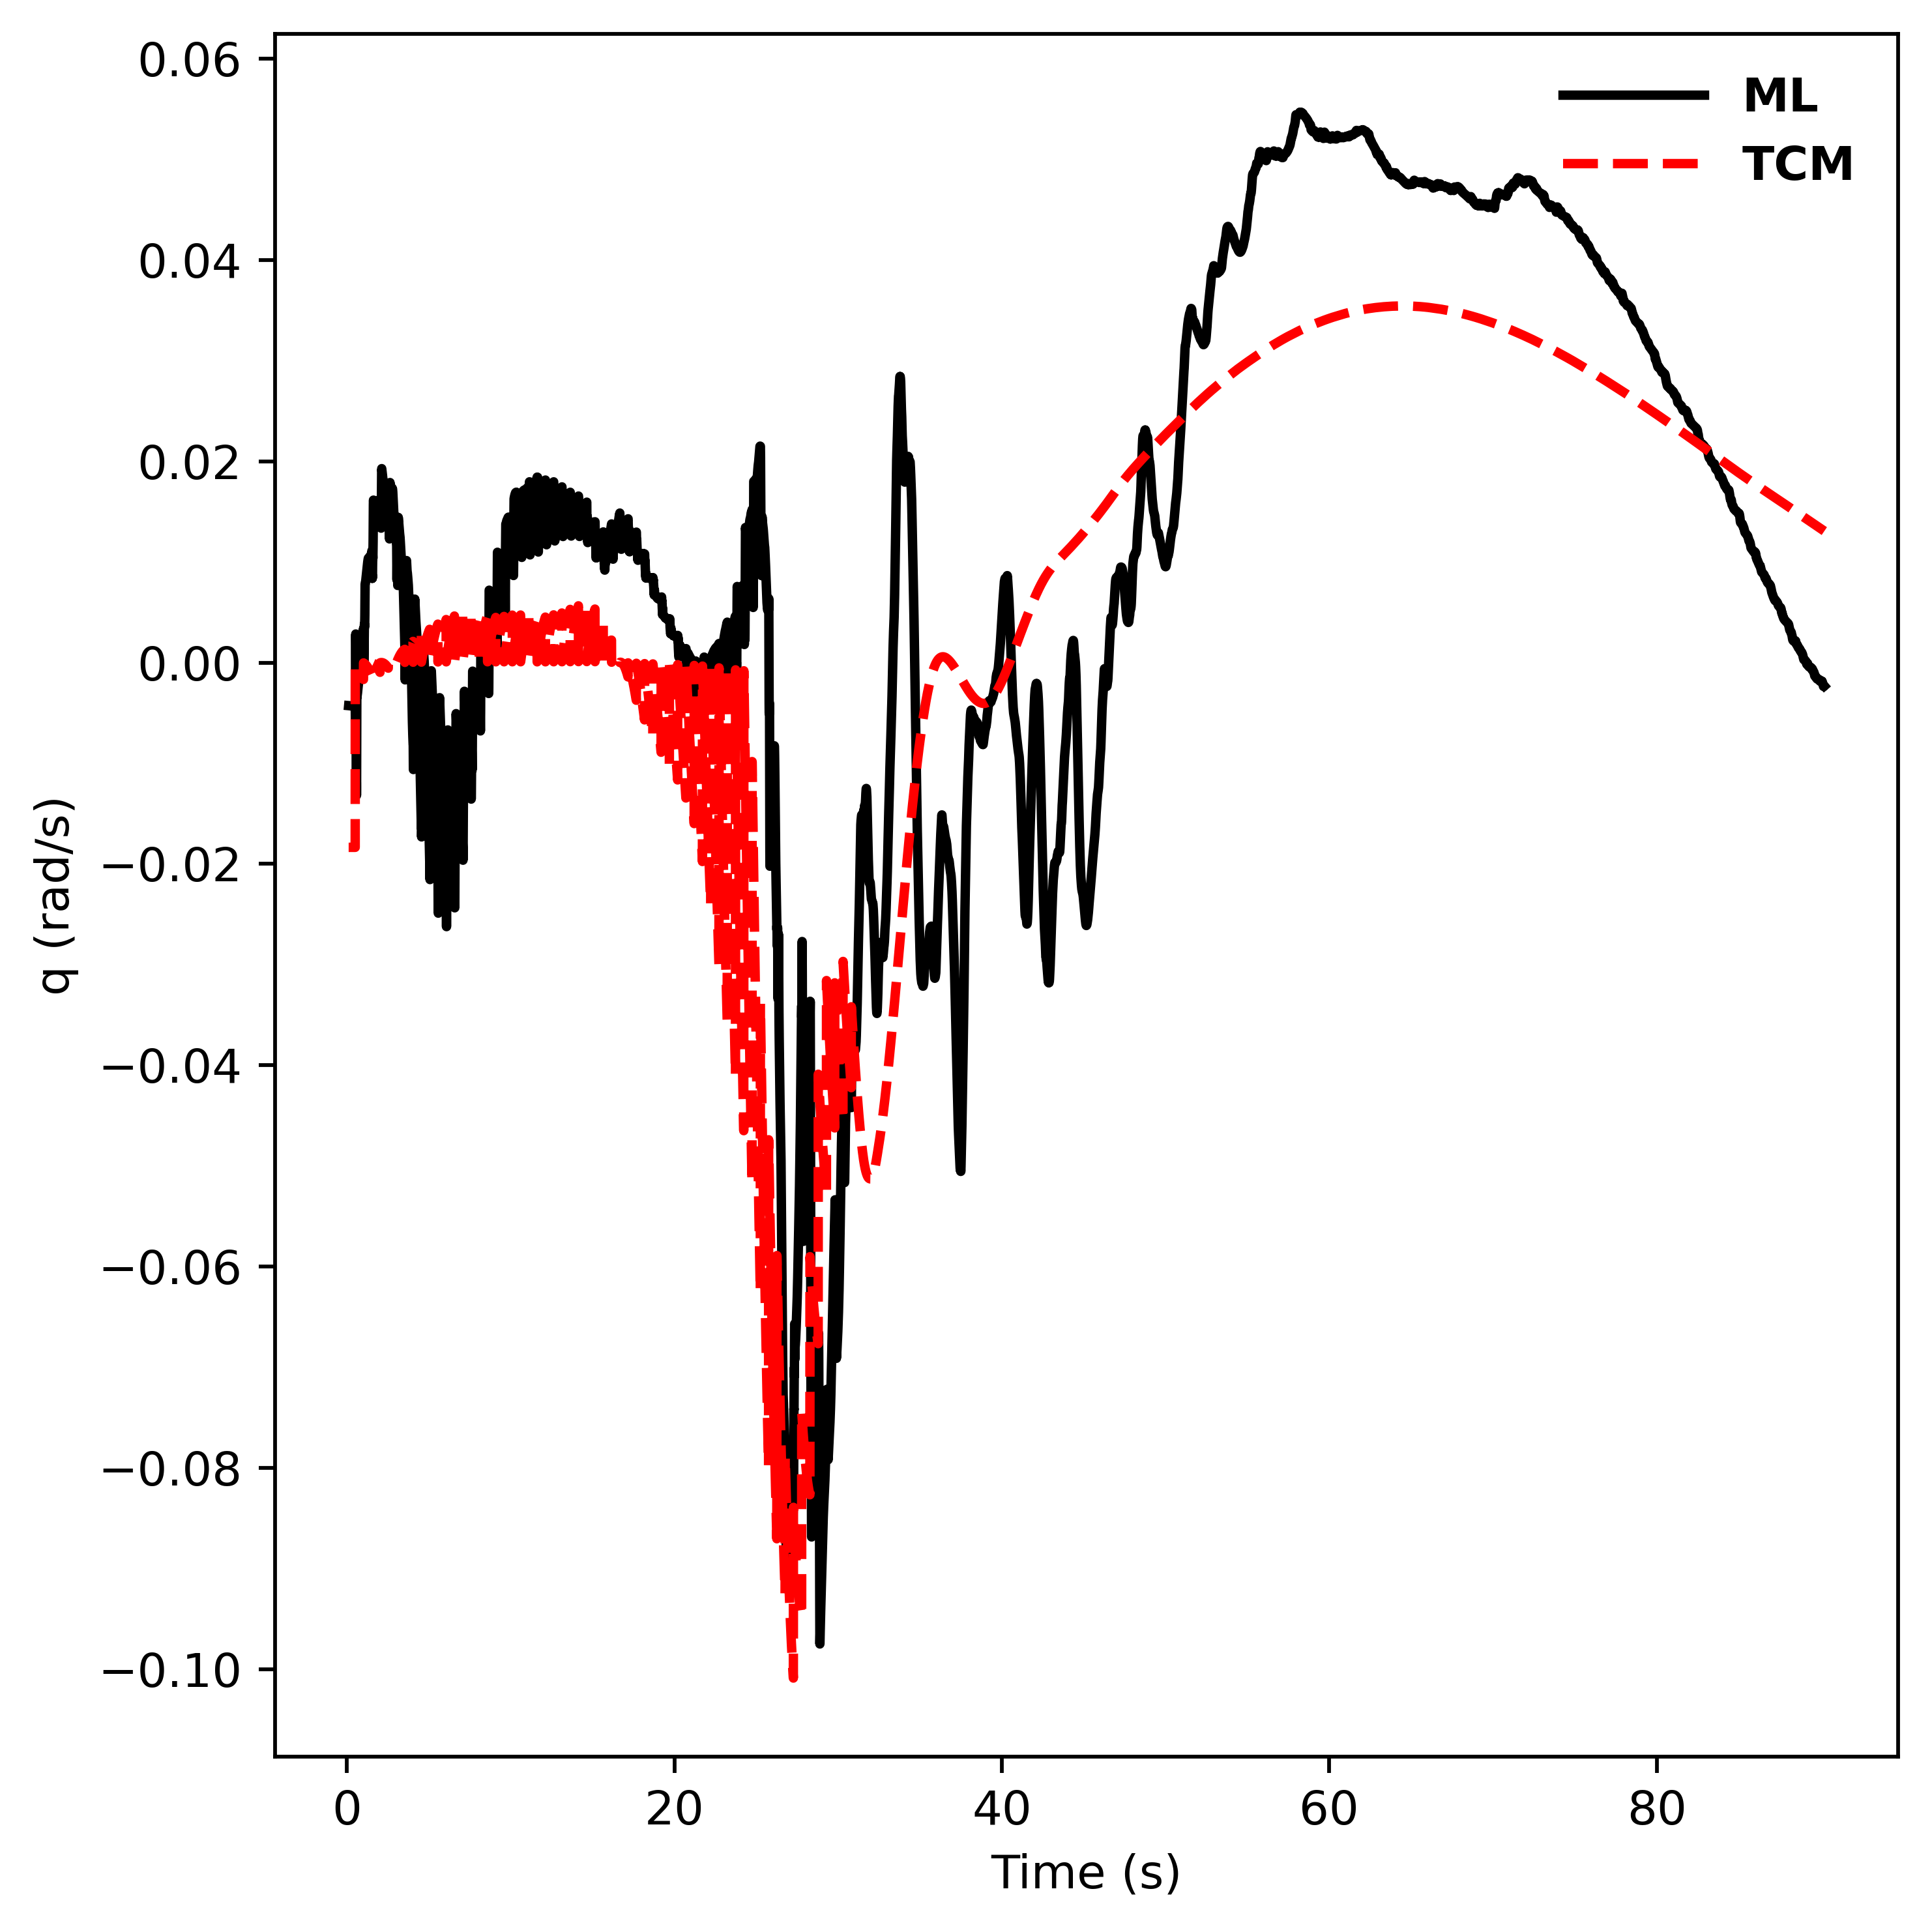

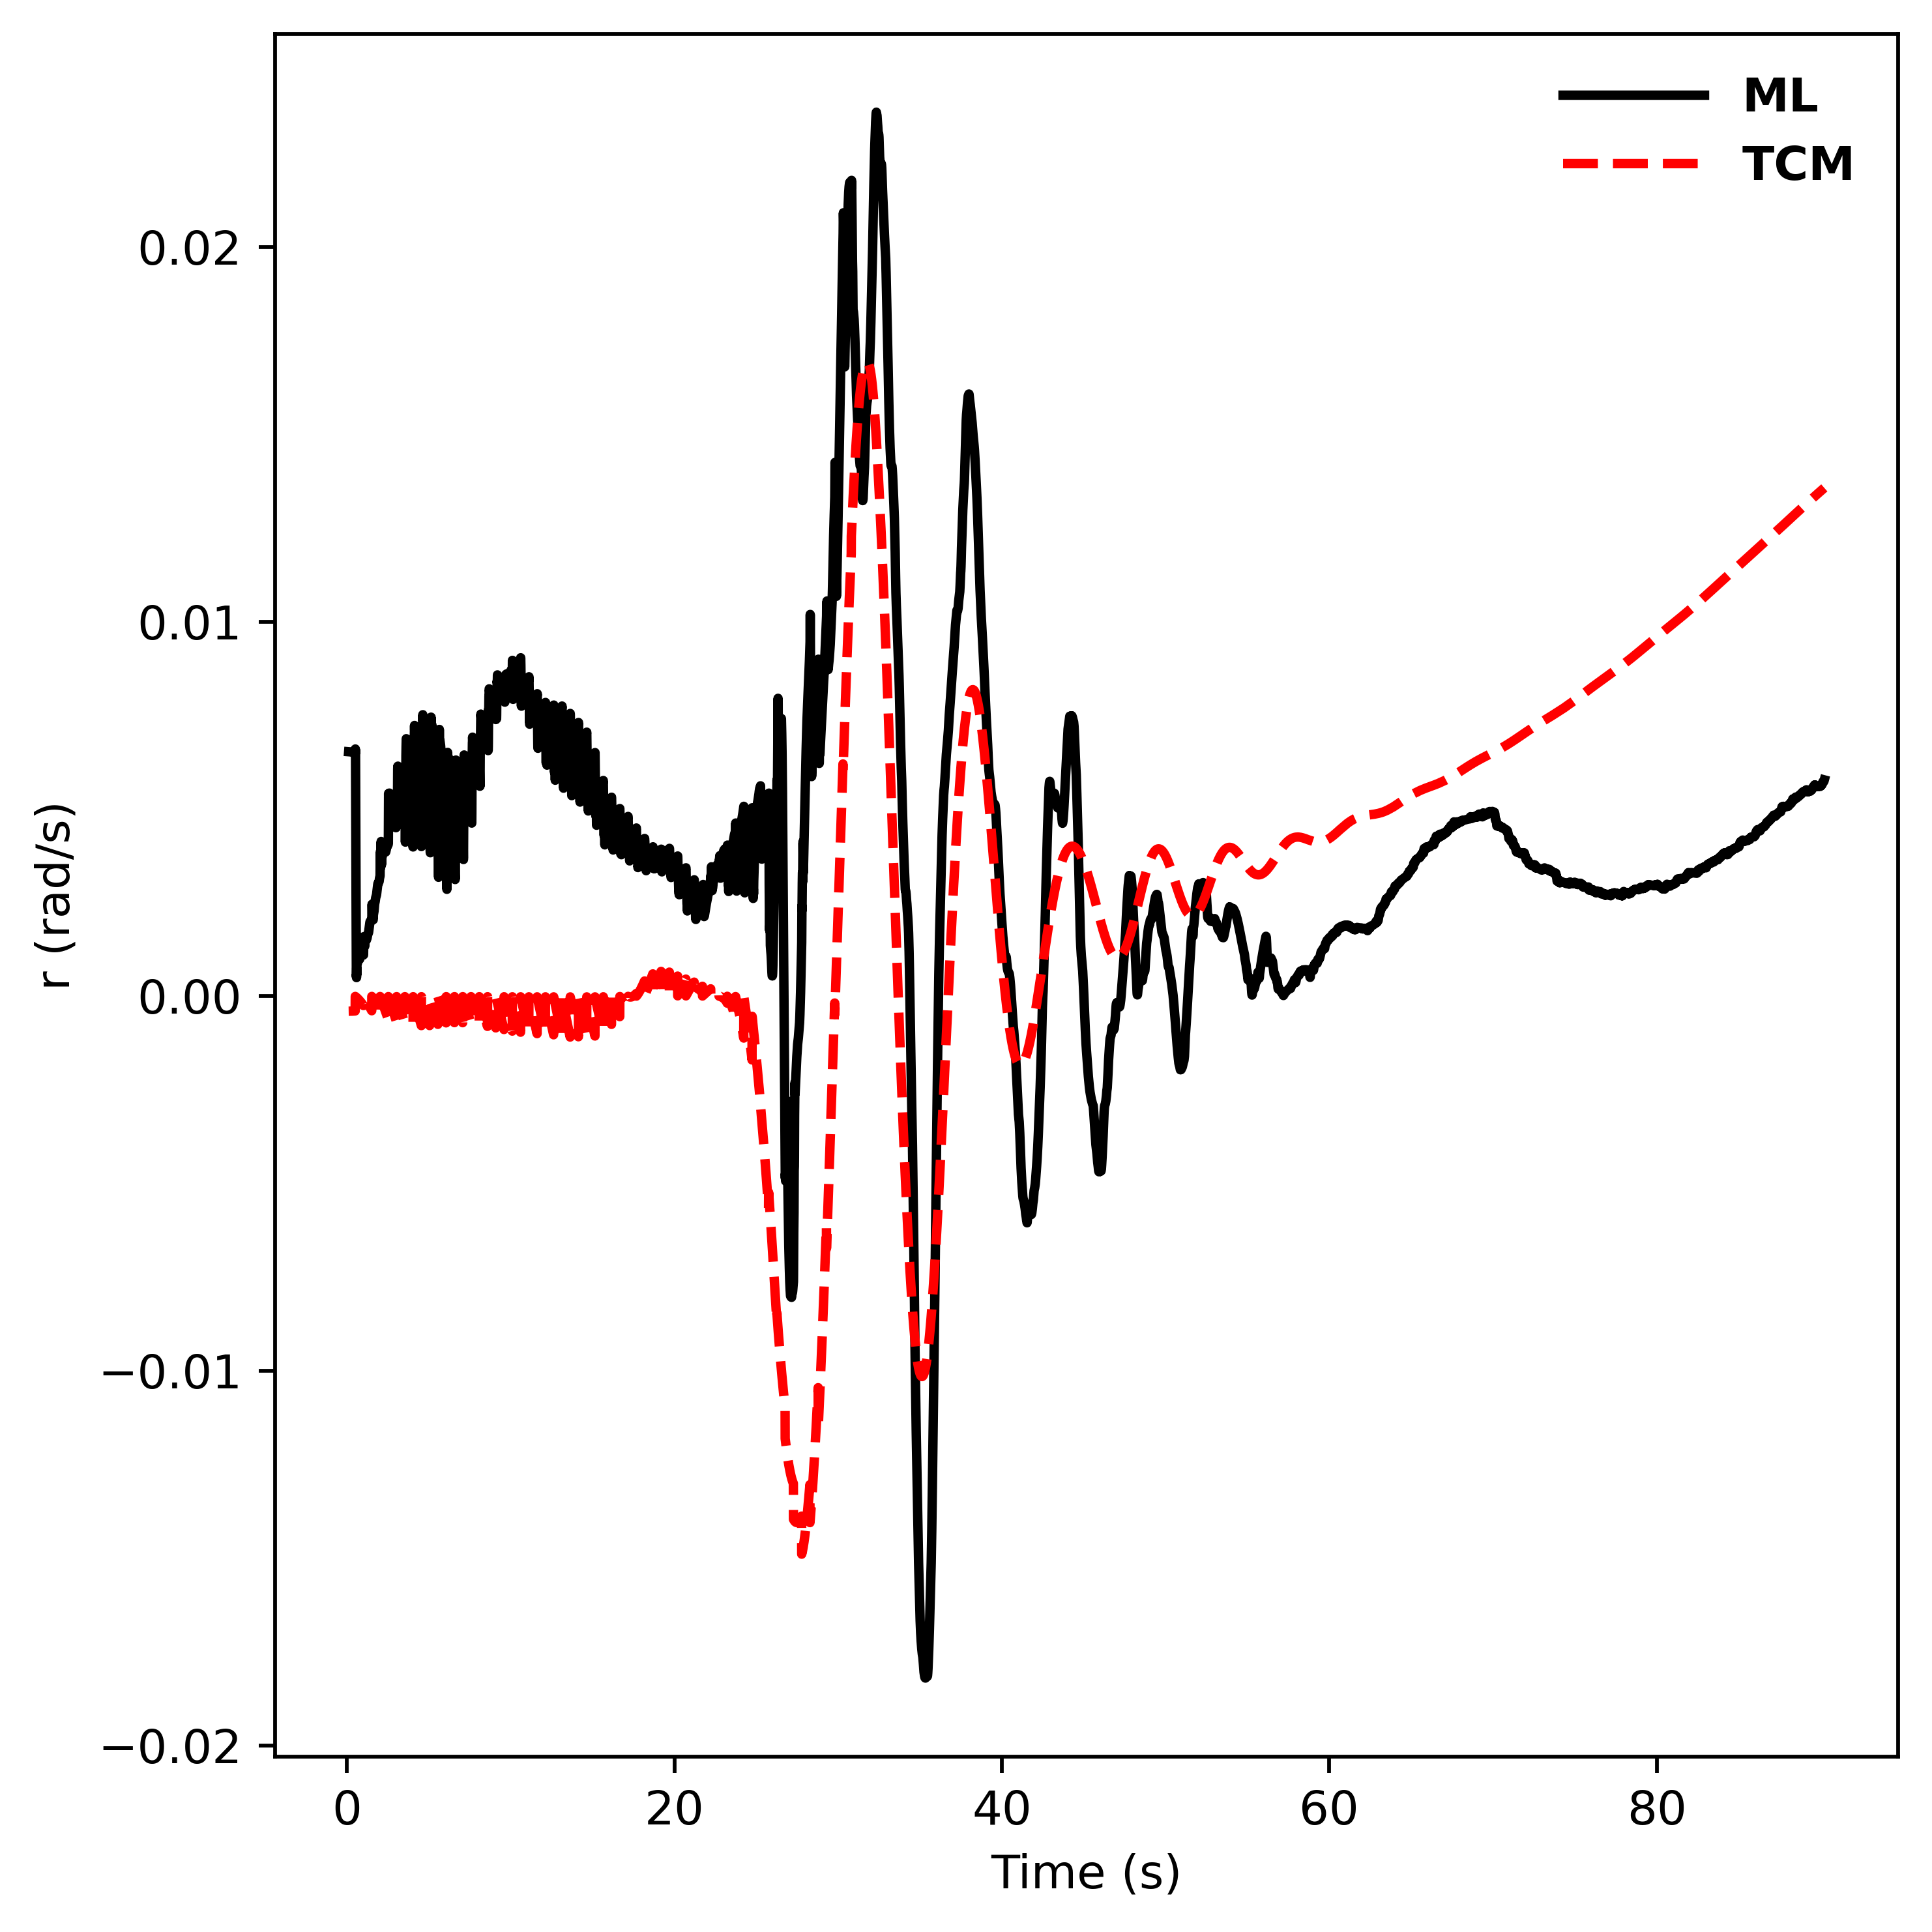

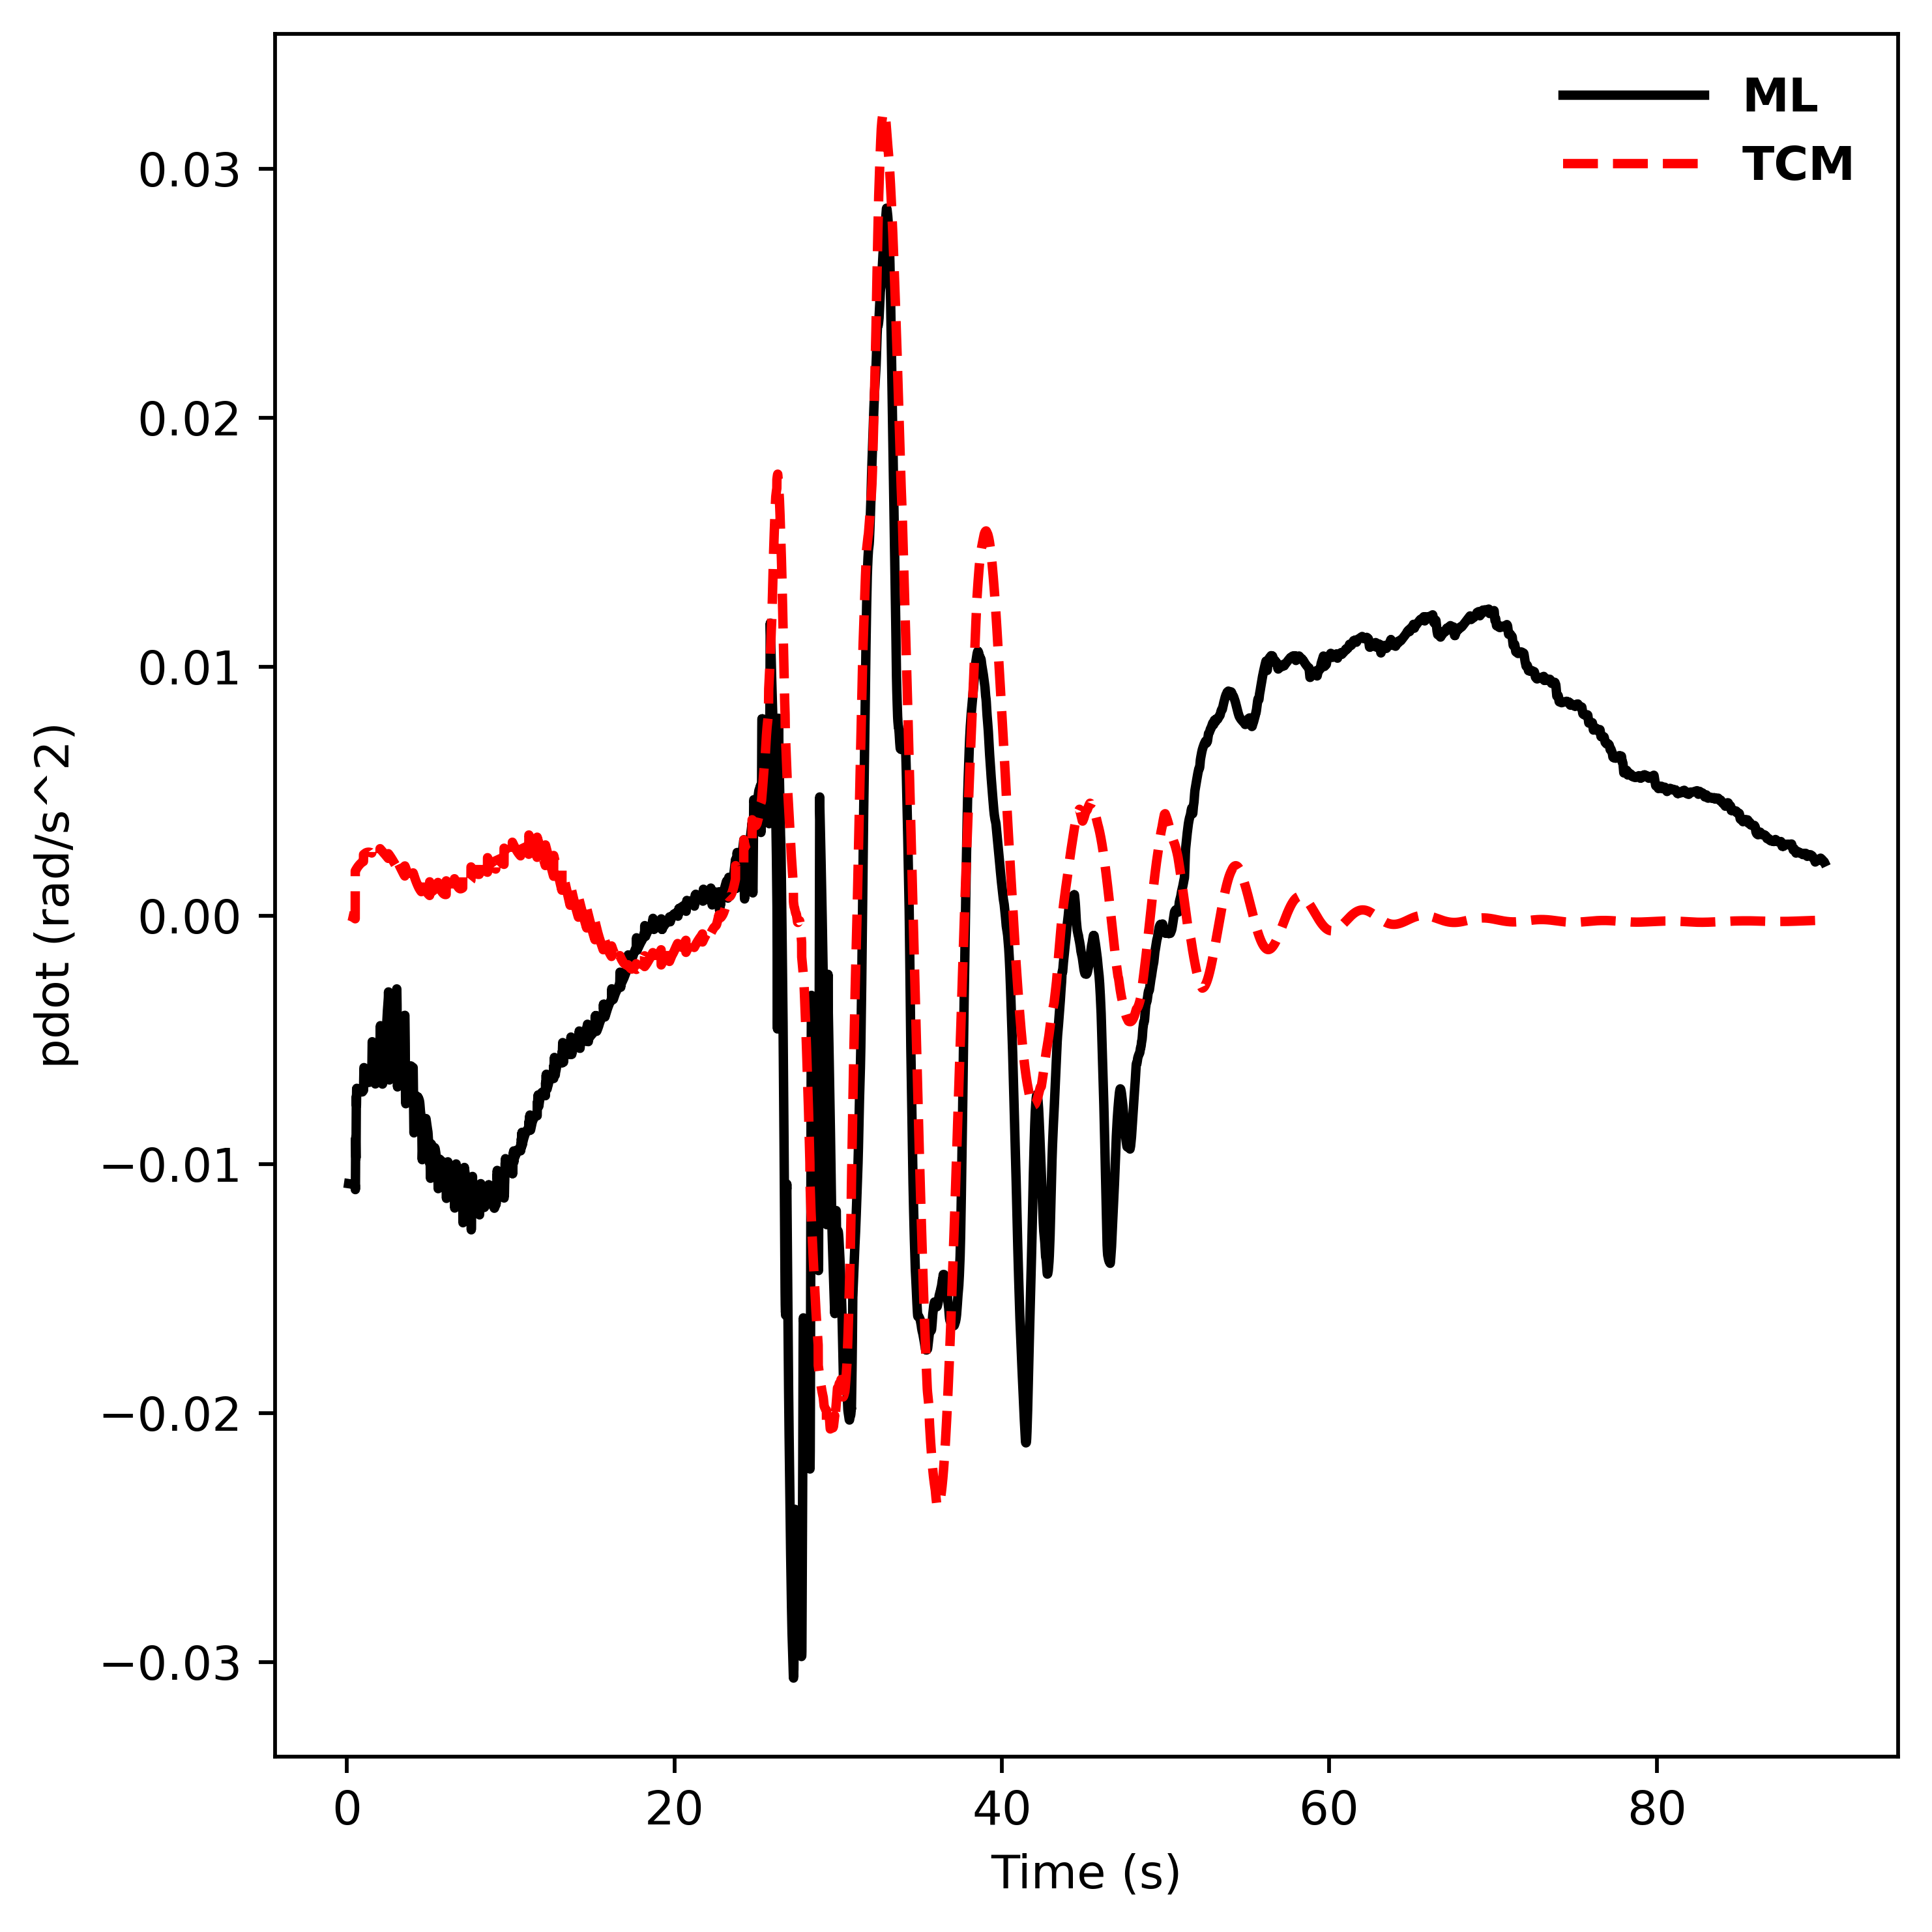

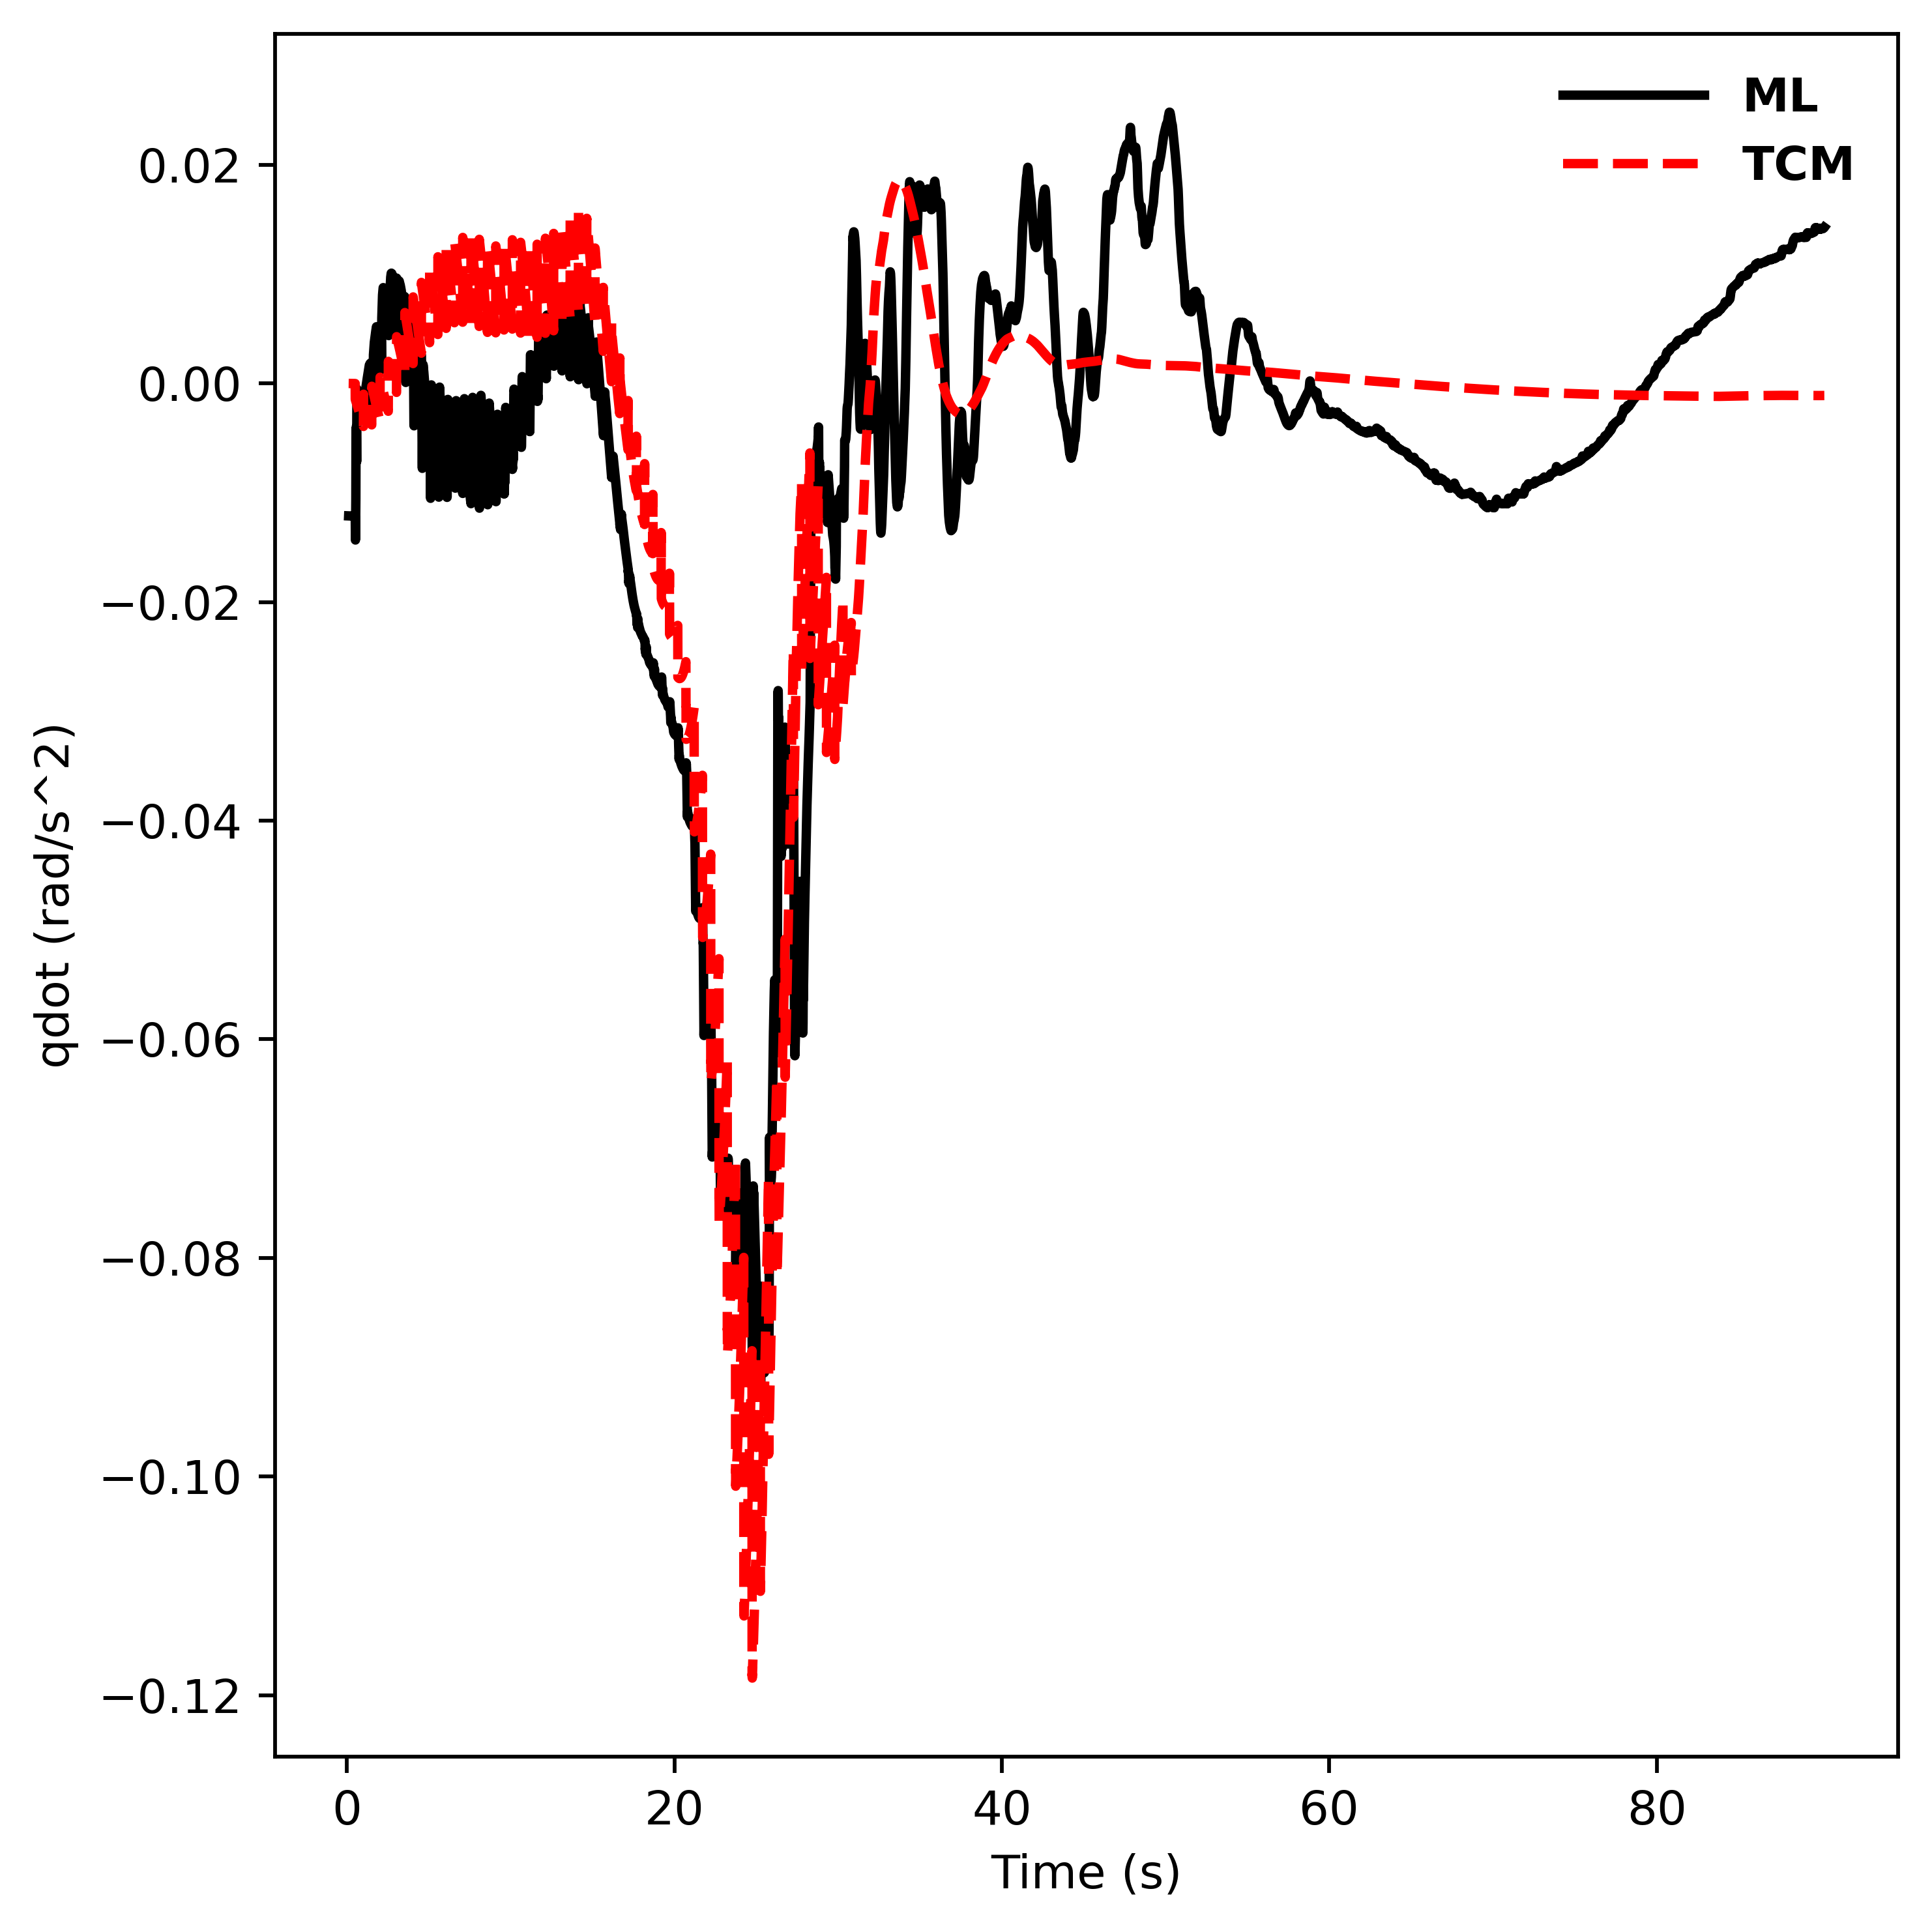

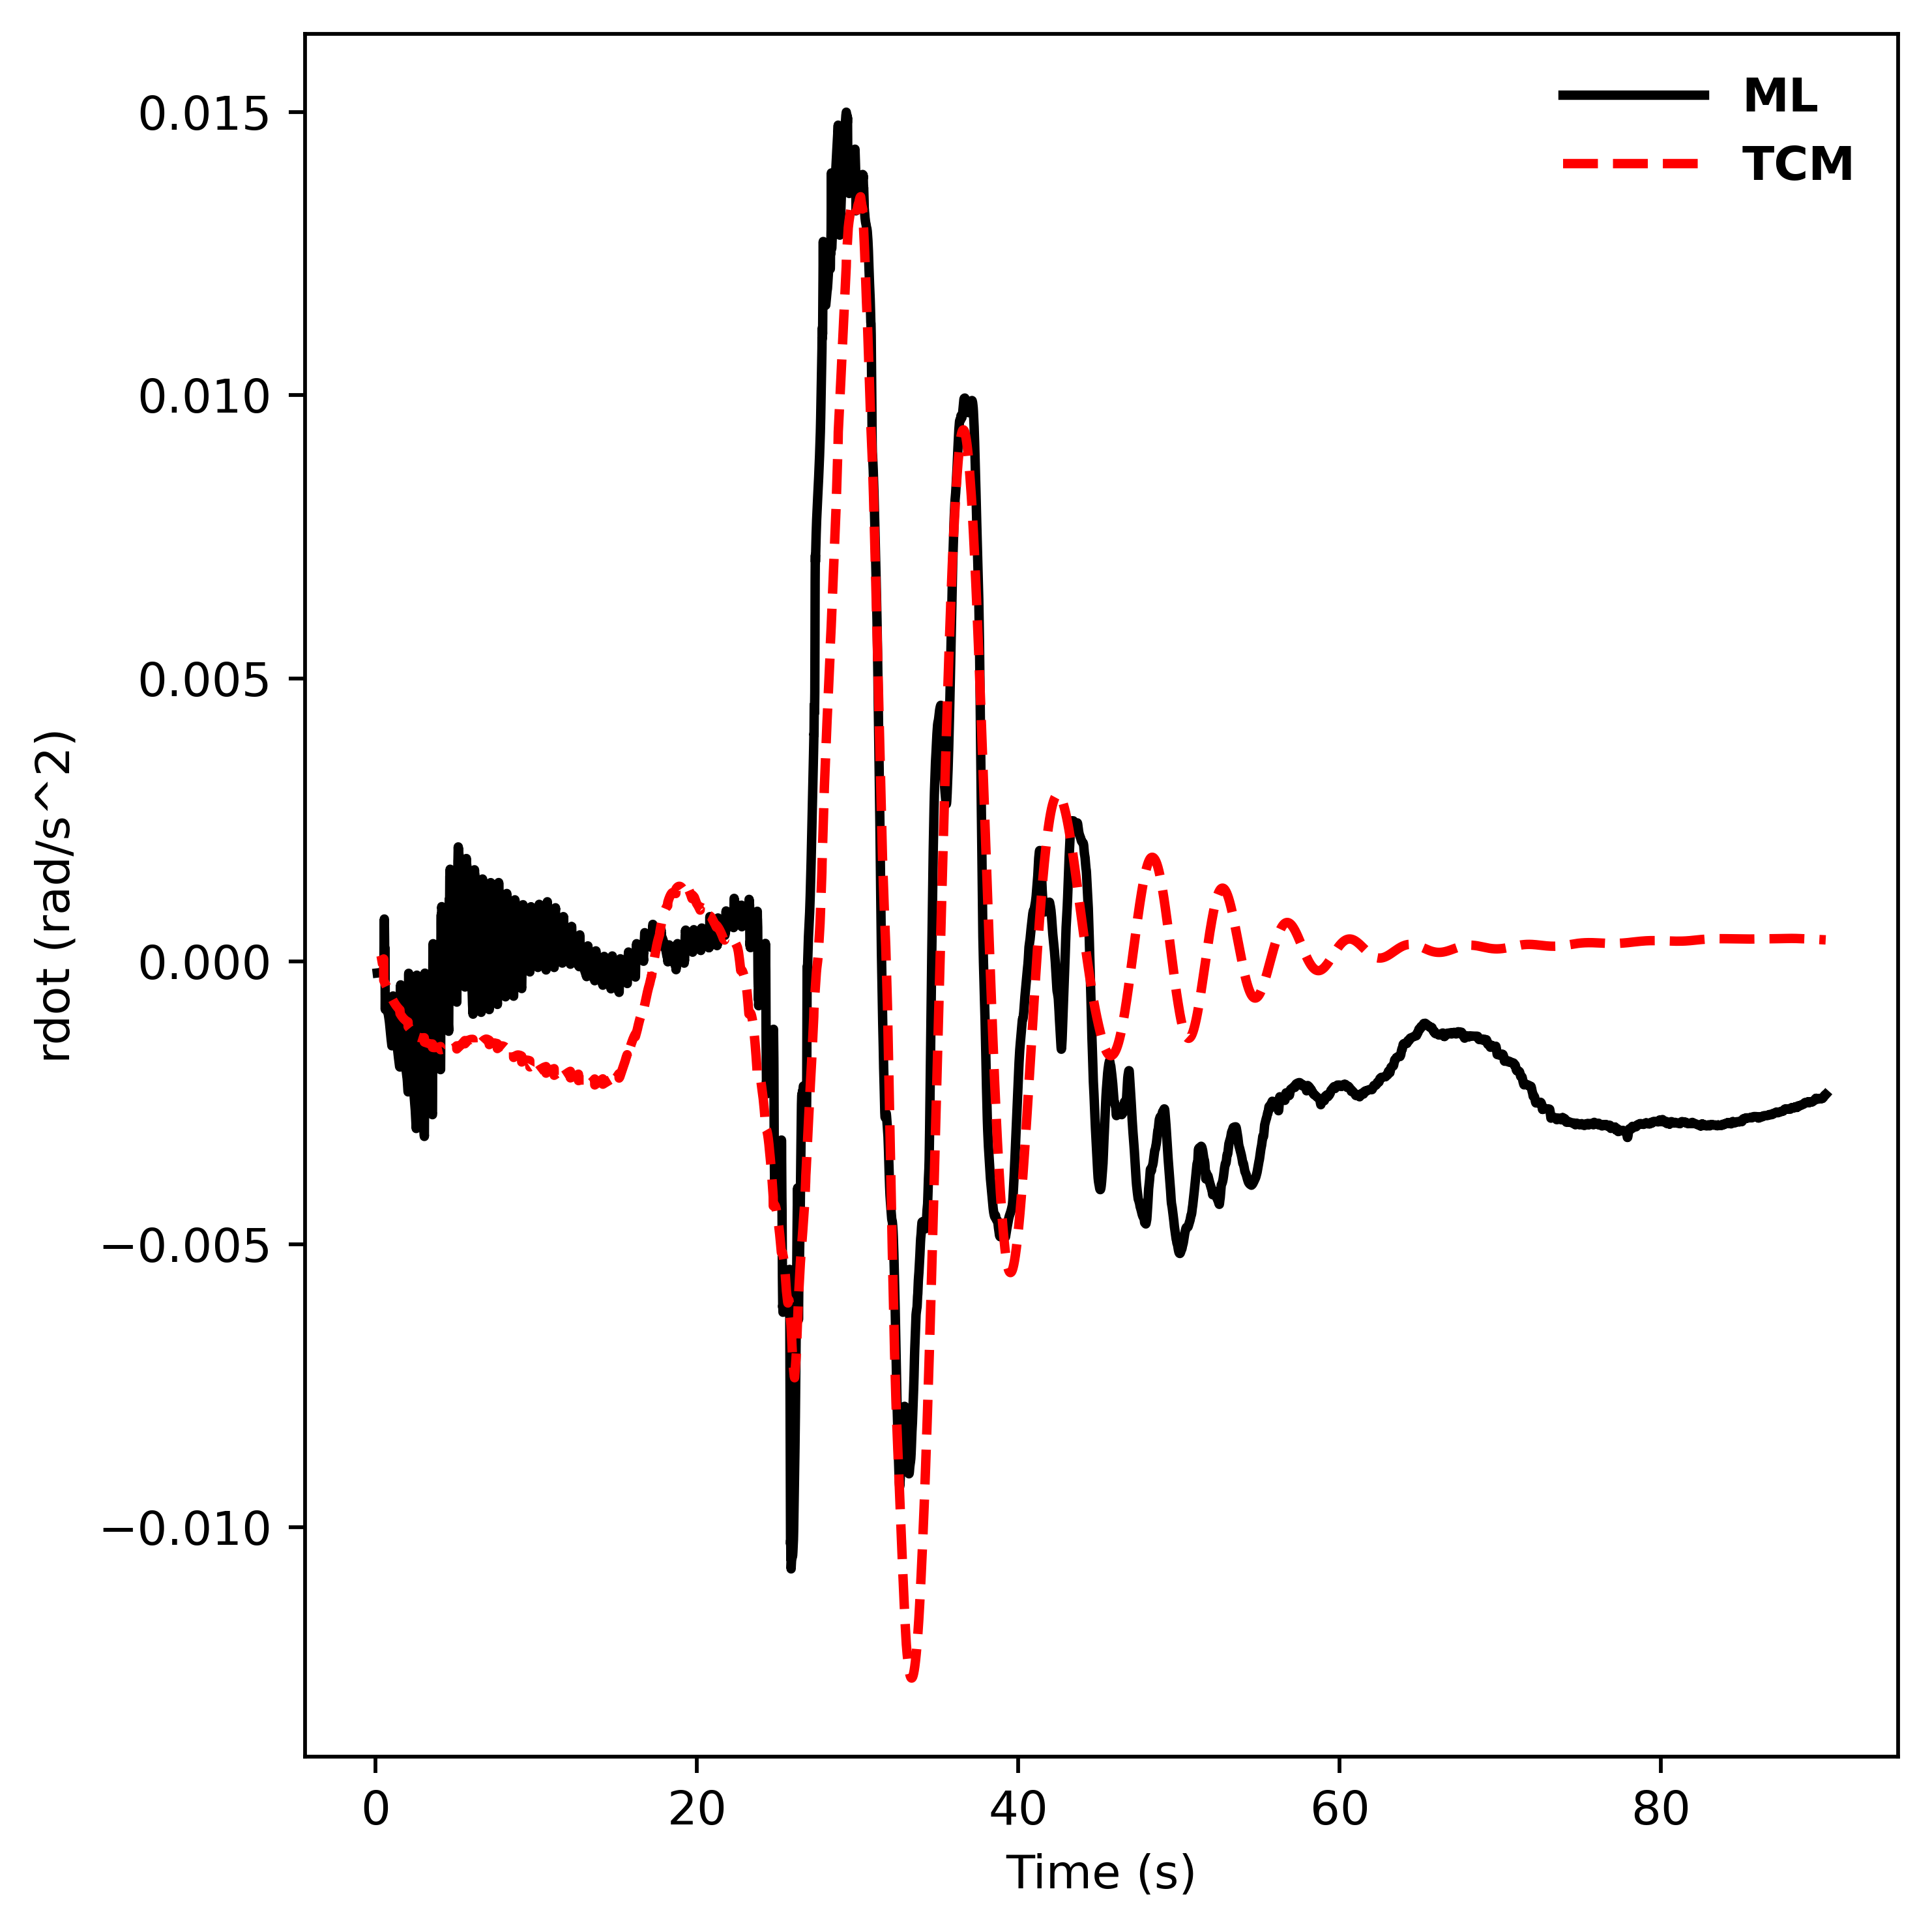

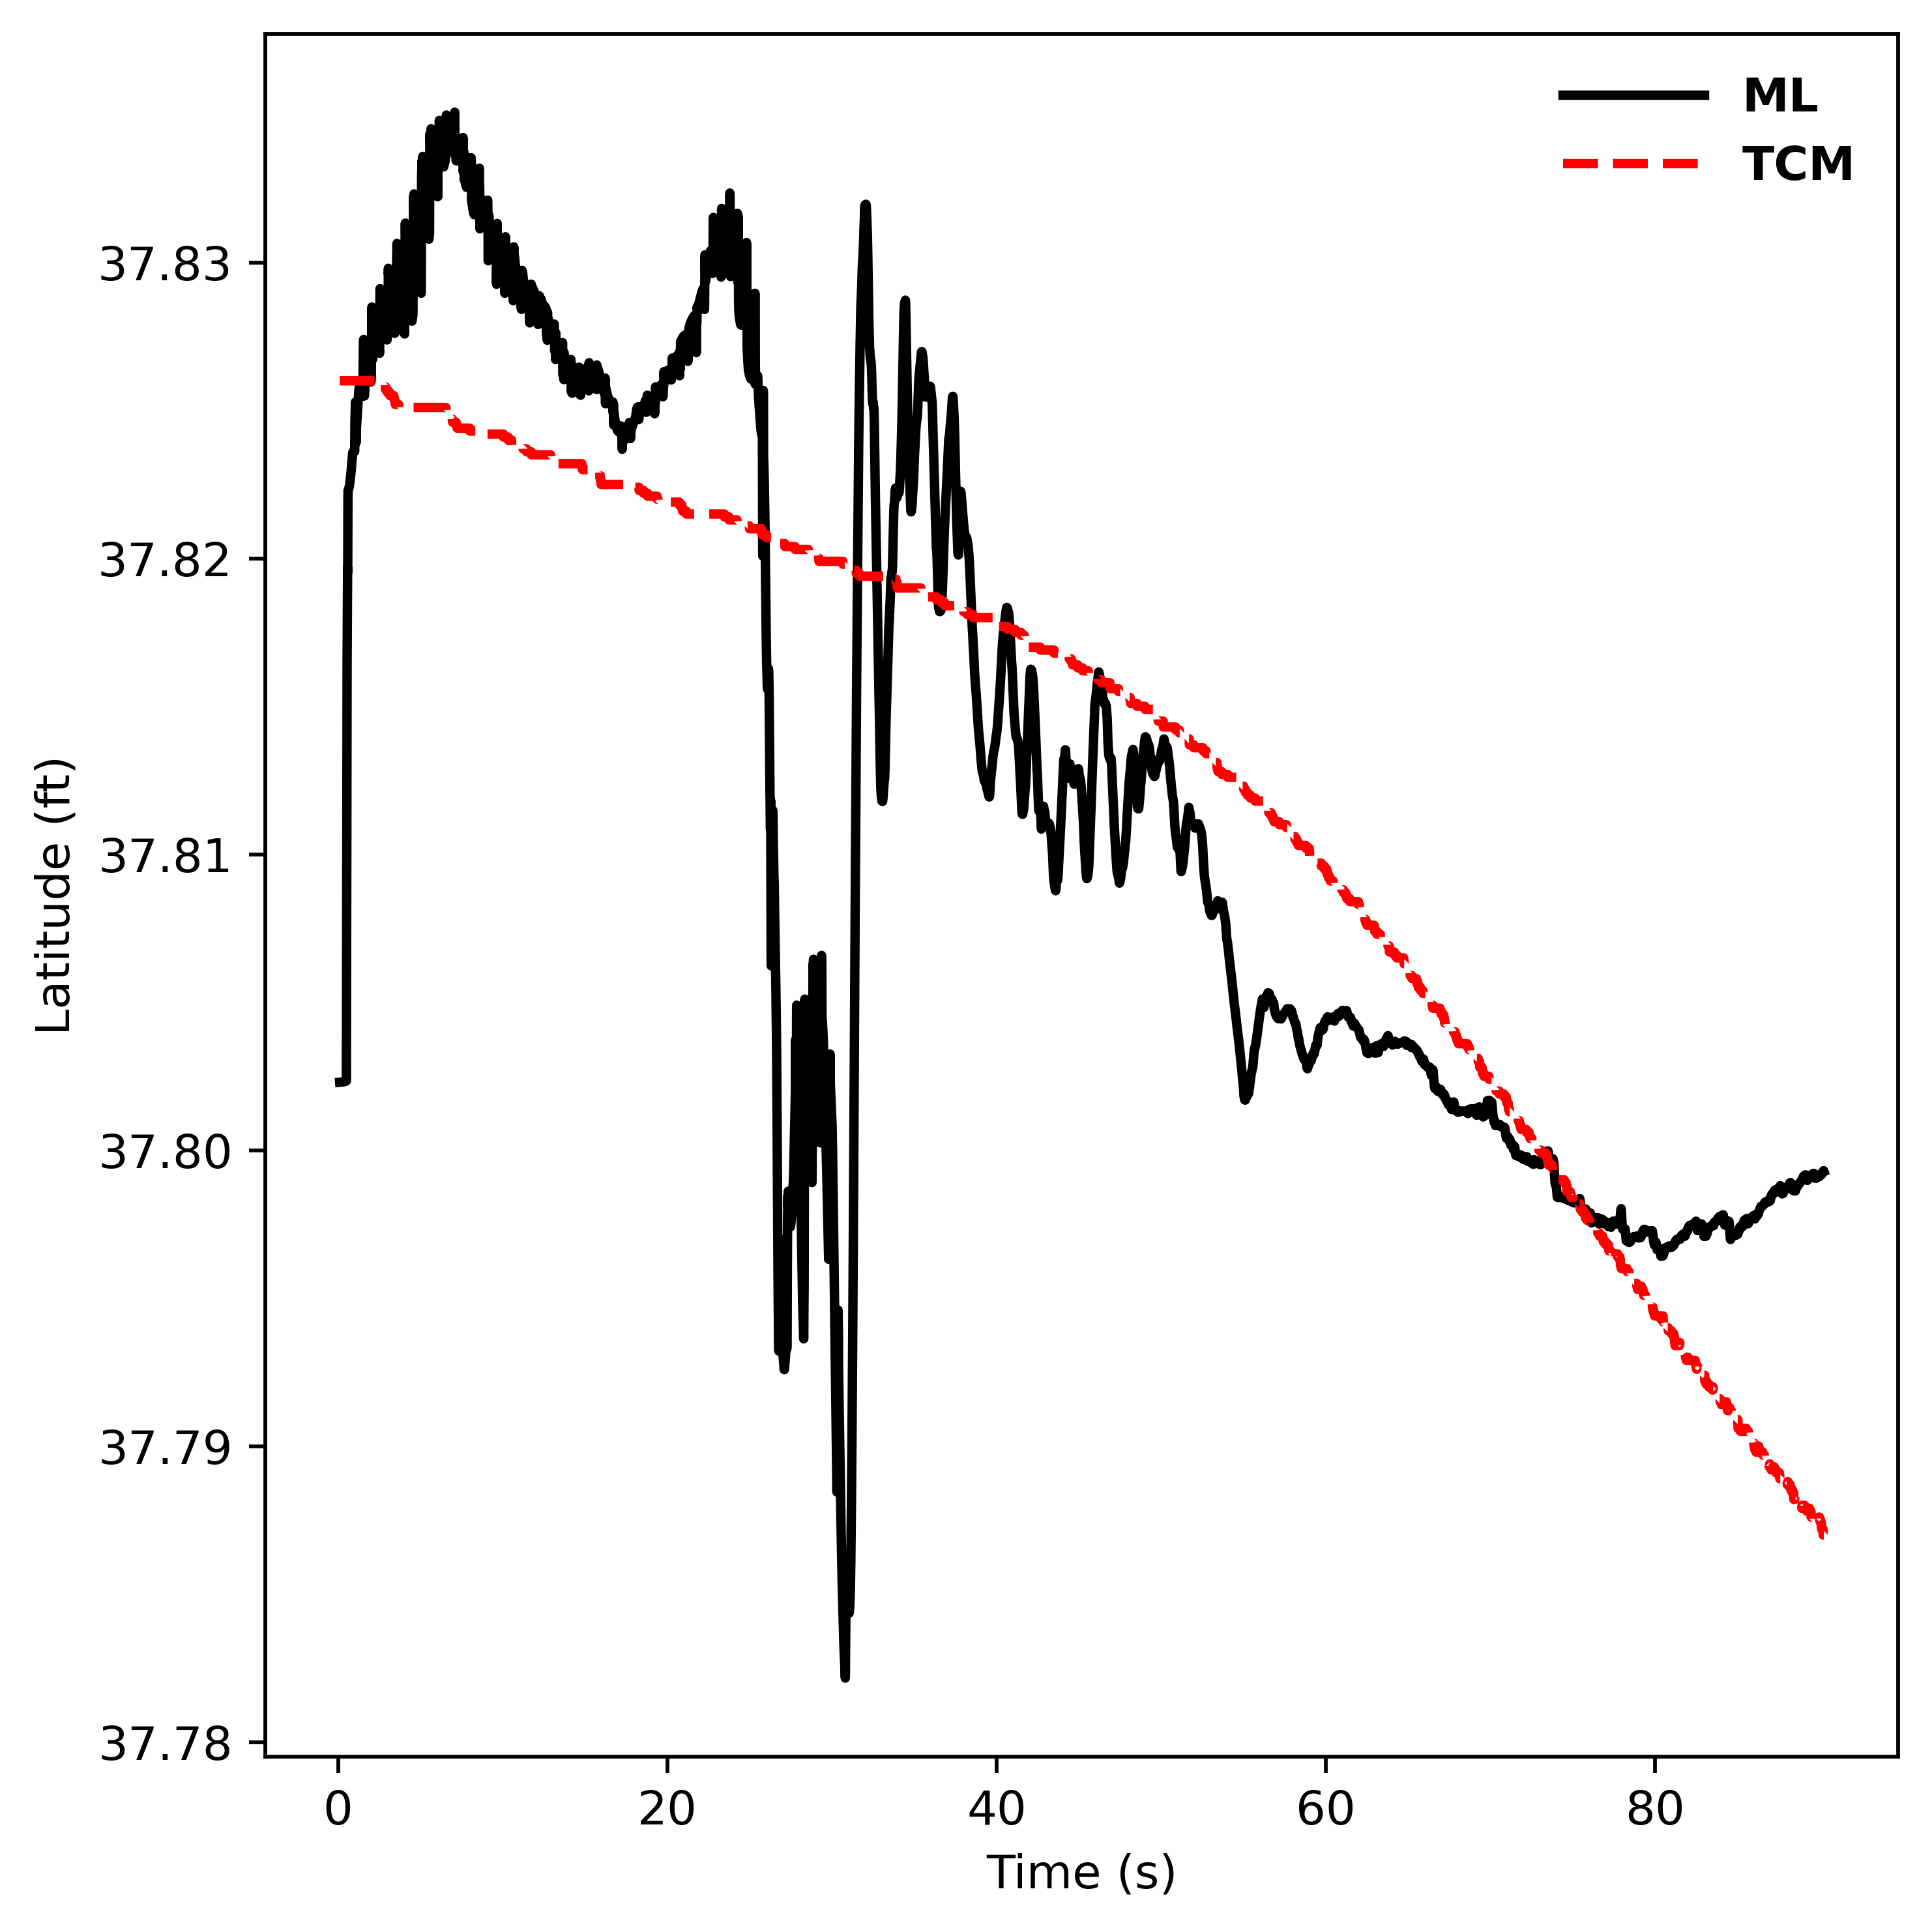

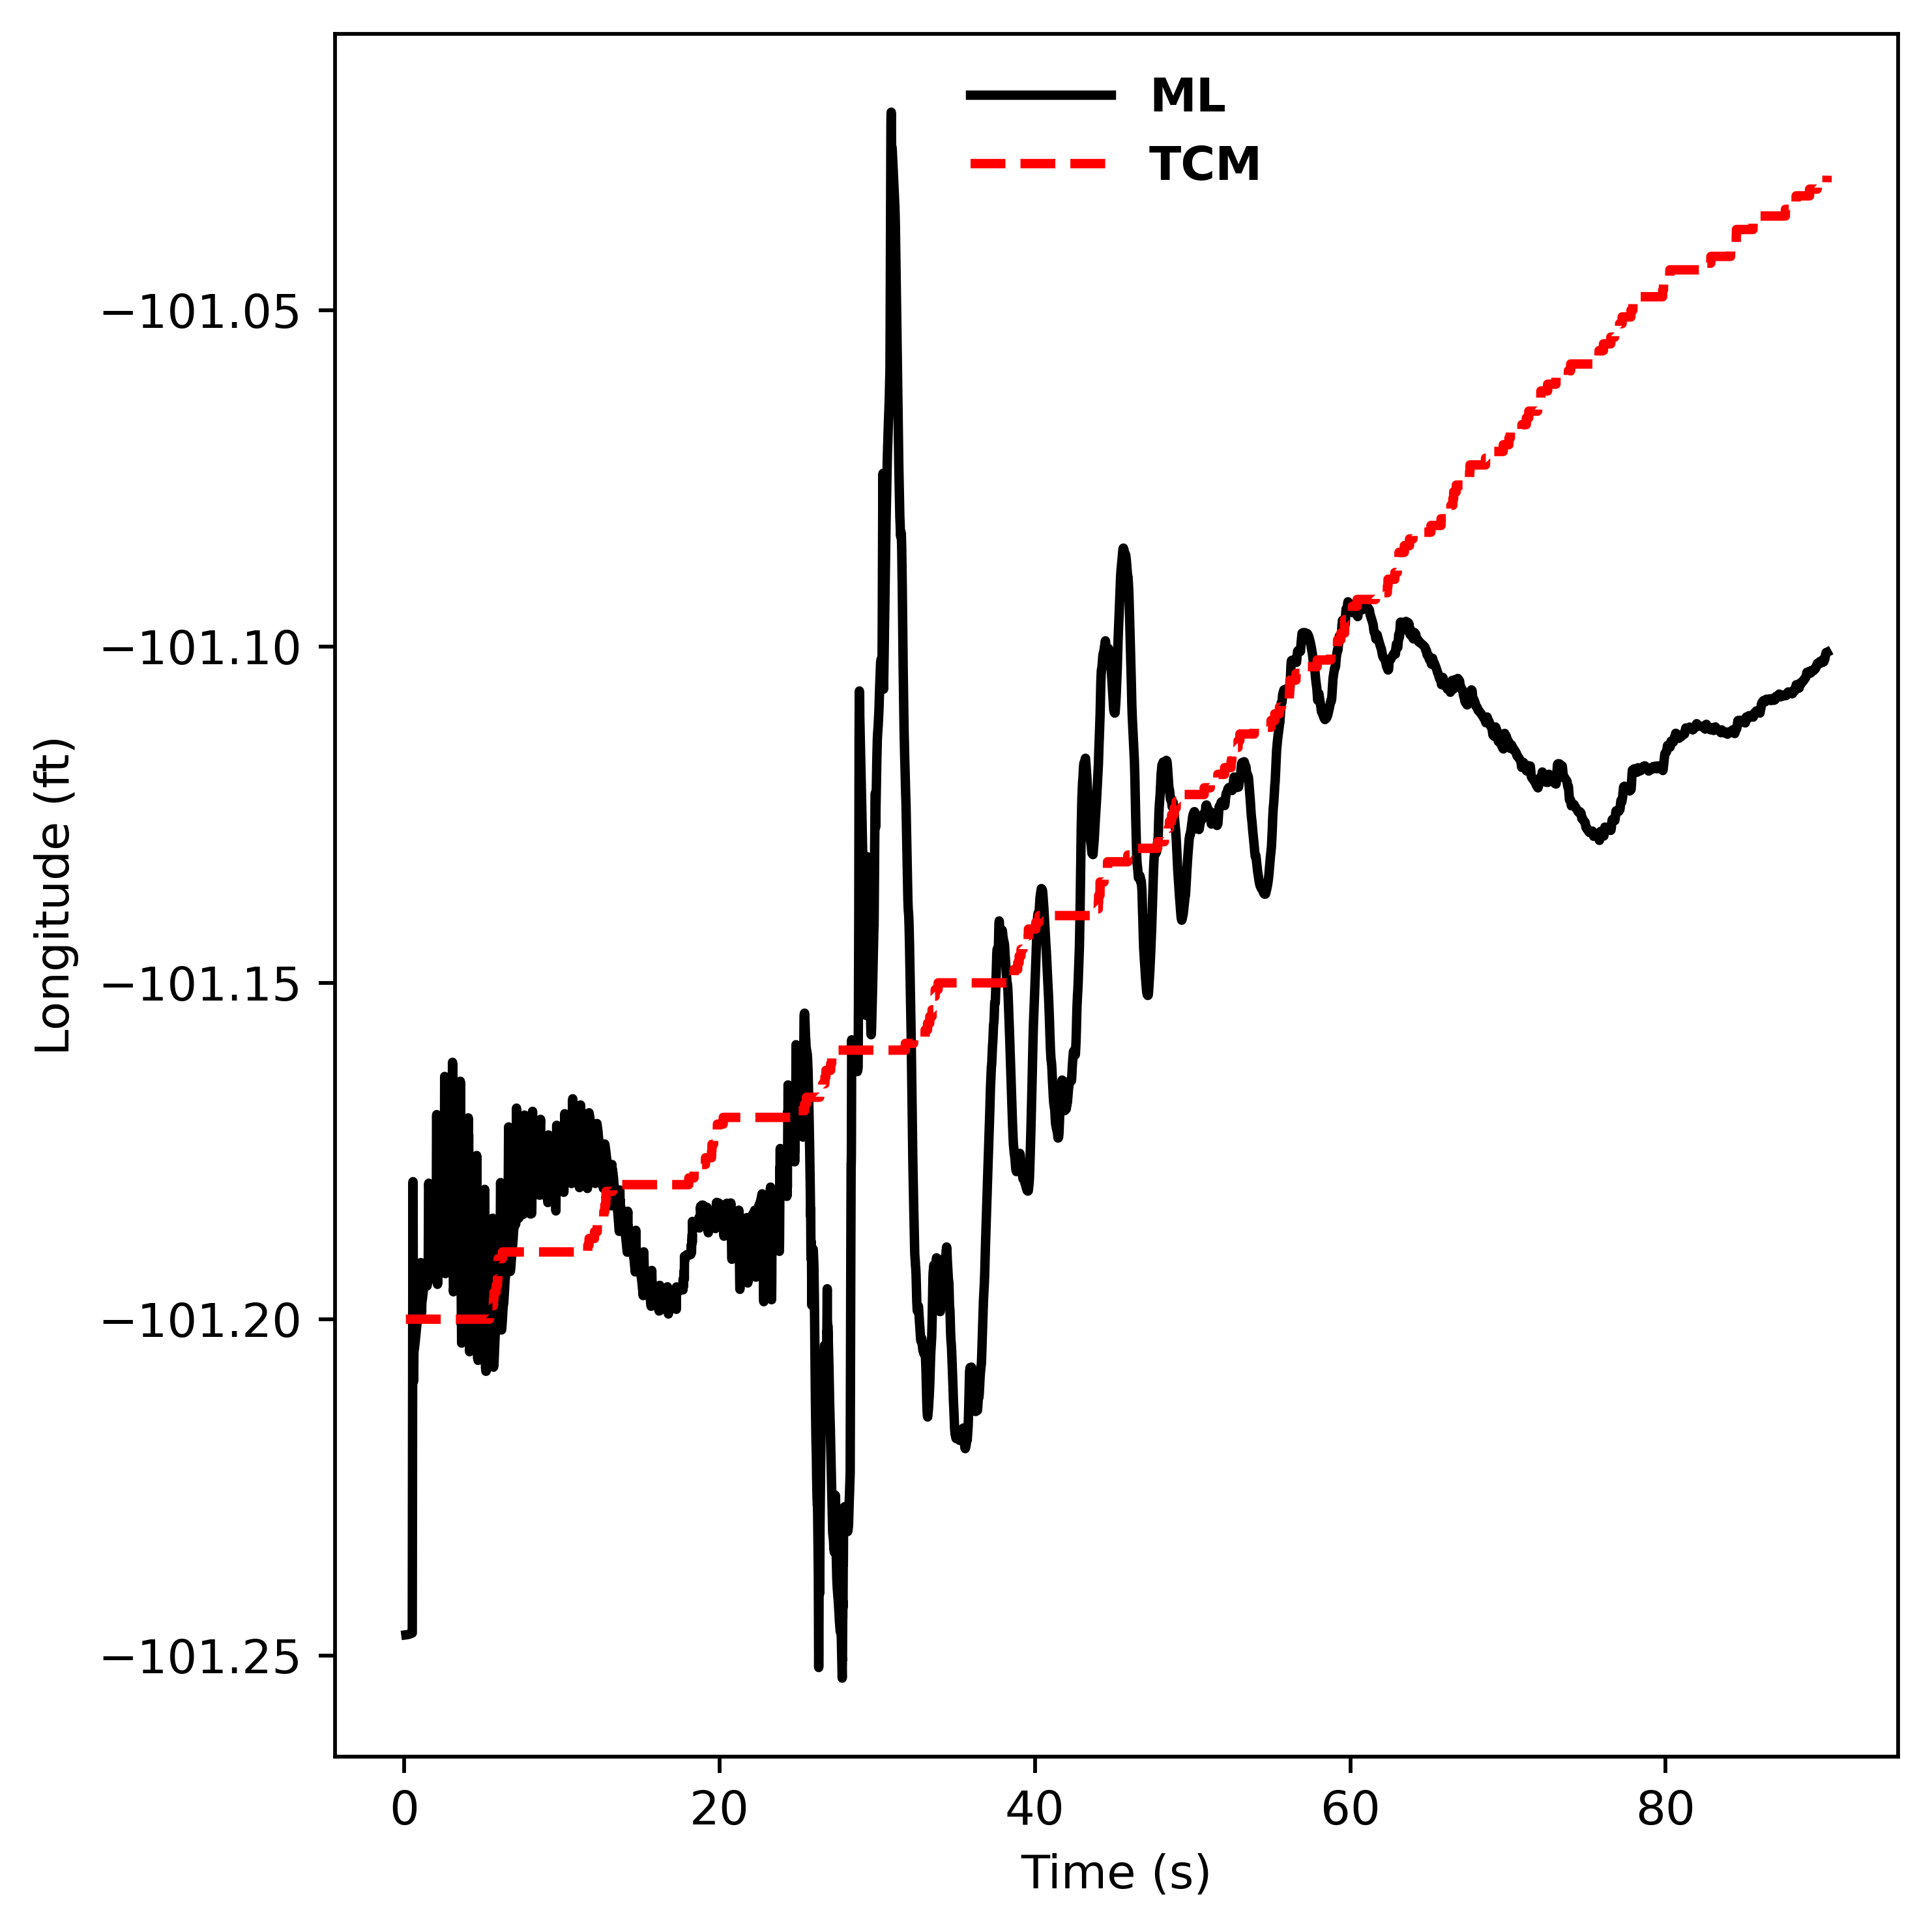

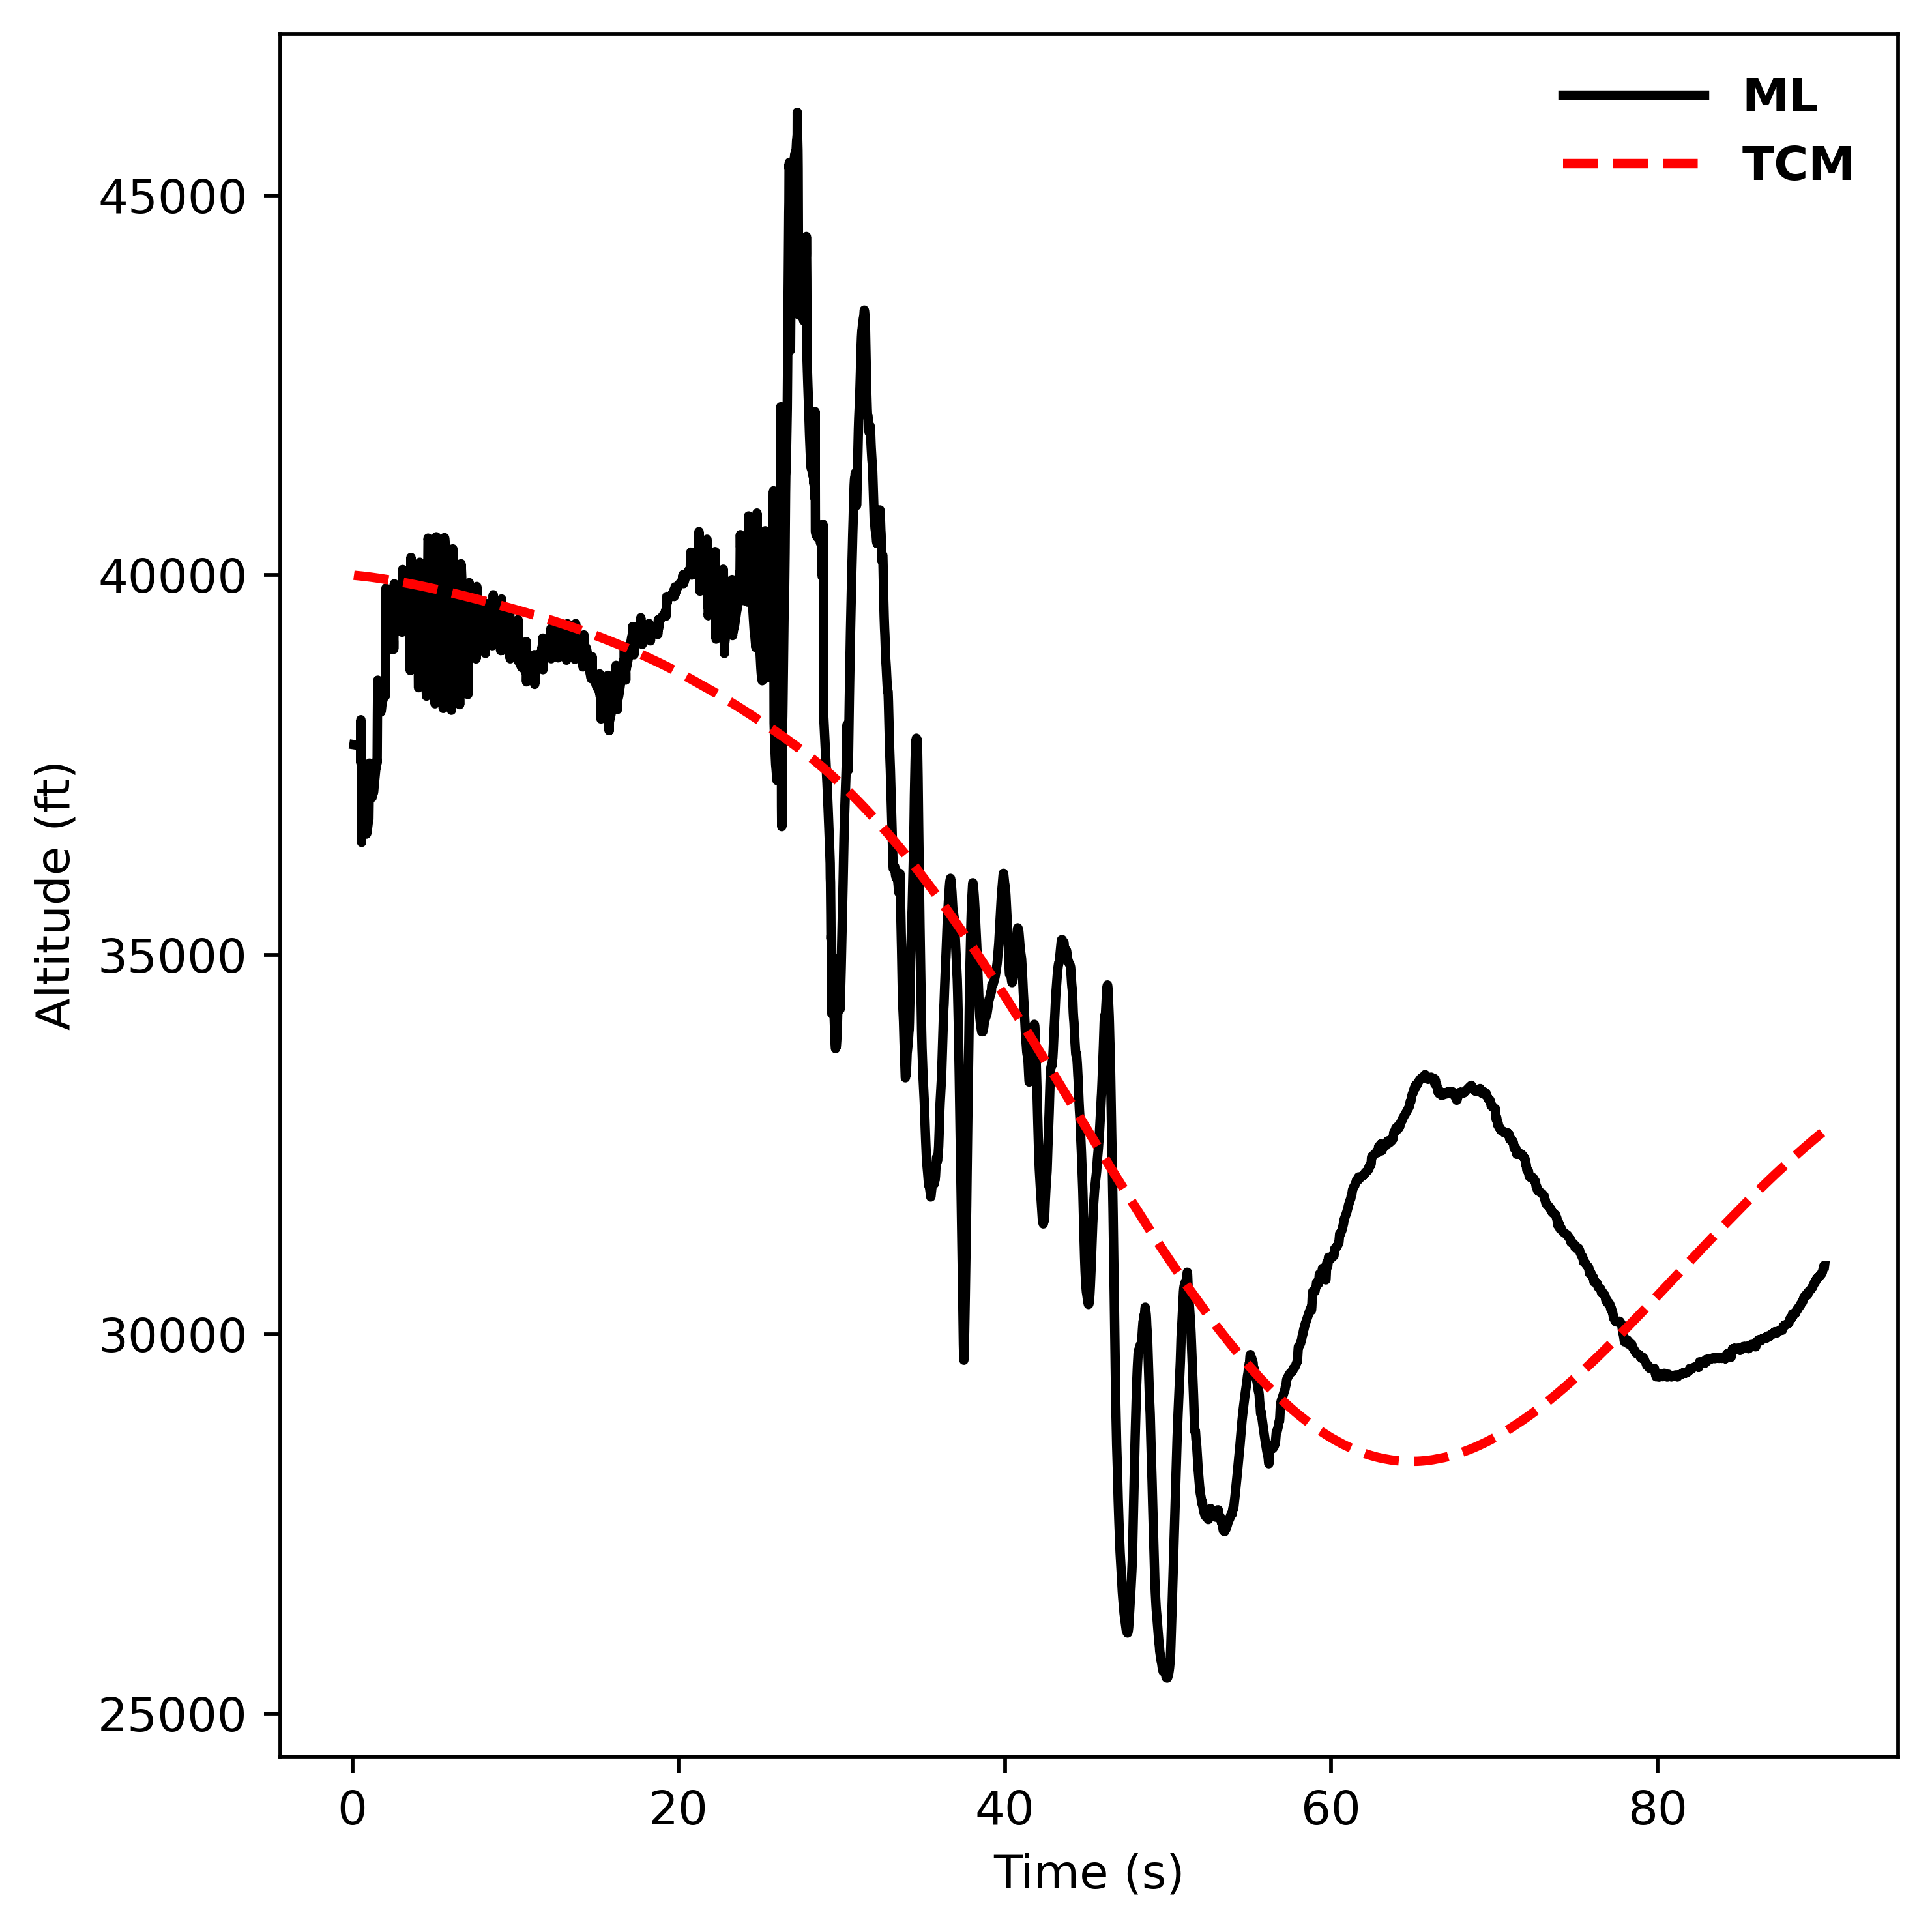

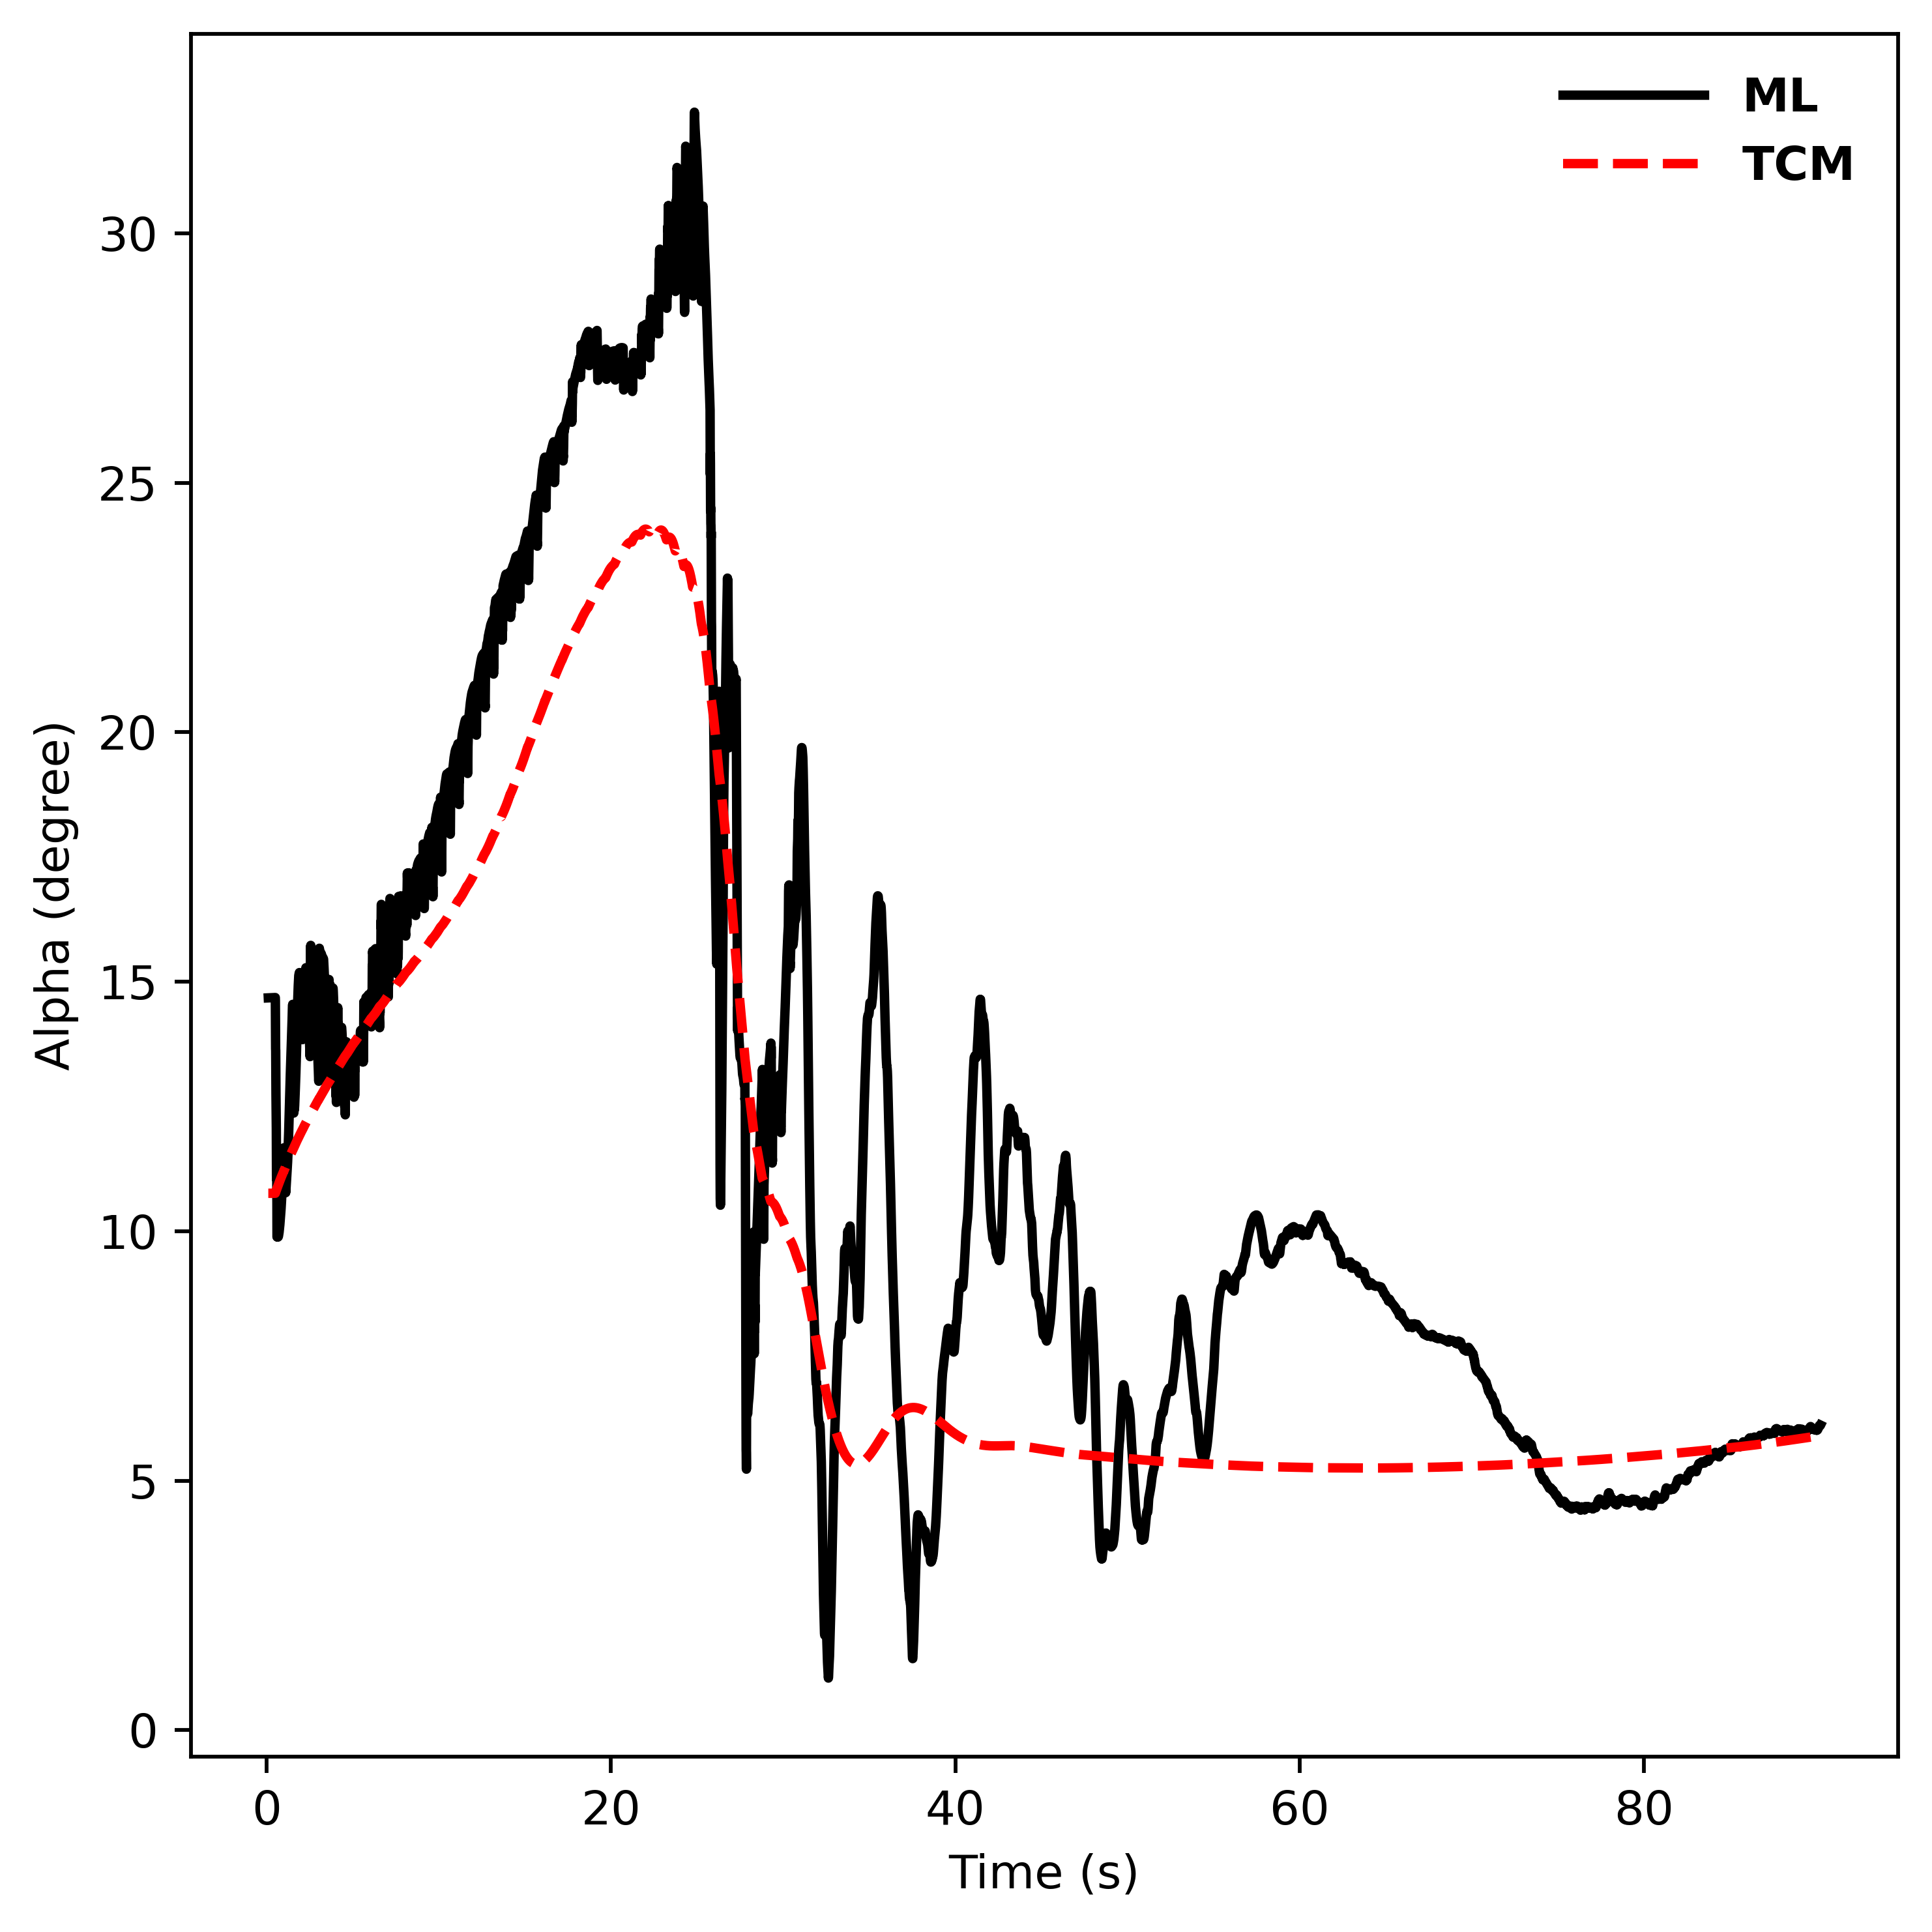

In [13]:
from utils import plotResponse

plotResponse(predictedData,orignalData,scaled_Data.shape[0],InitialT,TotalTime,window_size,gtm_dt,outDir,notebook=True)